# Birdseye CNN
Matrikelnr. 5504890

The goal of the project is to extract the birds-eye view (BEV) from the imagery of car cameras.
Specifically, we want to distinguish between drivable sections (roads) and non-drivable sections (houses, pavements, etc.).

In detail, a set of input images is mapped to a BEV of the situation [1], in the following image the more difficult task includes not only identifying rode segments but also objects:
![image.png](attachment:image.png)
#

## Motivation
The BEV can enable self-driving cars to plan ahead, as they allow for a more accurate representation of surrounding objects.
Multiple approaches to computing the BEV exist [2]. These inlcude:
- Inverse perspective mapping using homography. The surface is assumed to be planar. With knowledge of the camera angle, one can remap the situation to a BEV. Drawbacks include distortion (because an horizontal plane is assumed) and low precision for objects further away from the image, as they are represented by less pixels in the original image [3]:
  ![image-2.png](attachment:image-2.png)

- The surrounding environment can be reconstructed by using lidar sensors.
- Vision based neural networks can be trained in conjunction with labeled BEVs to perform inverse perspective mapping.




# Methodology

- The dataset is constructed with the help of google maps and the street view feature.
- A cnn is trained to construct the birds eye view with the help of the (street-view, maps BEV) pairs.


[1] https://ieeexplore.ieee.org/document/9294462 <br>
[2] https://www.youtube.com/watch?v=TzXuwt56a0E <br>
[3] https://towardsdatascience.com/a-hands-on-application-of-homography-ipm-18d9e47c152f

## Dataset


The dataset is assembled using the standard google street view interface, in an automated manner. The basis for the groundtruth is then the graphical BEV:
![image.png](attachment:image.png)

The automation of obtaining the datset from google maps proved rather difficult, and different methods were explored (including using open-cv to determine road angles).
It is settled on an implementation which is unaware of the possible driving direction (It is non-trivial to determine which way the road faces from the input given). So the street-view images are taken in North, East, South and West direction, with the BEV having the correct orientation.
The extraction code can be found here: https://github.com/AmosDinh/CNNbirdseye/blob/main/maps_builder.py

Given the BEV, the target map is extracted, which represents the possible driving/walking area:

![image.png](attachment:image.png)

One problem is that road segments are not connected correctly, since text or symbols occlude the road sometimes.
Again it is settled on leaving the target BEV as is.
Following methods achieved no success (due to time and computing limitations):
- open-cv based
- training a CNN (ResNet, UNet) on generated data: Data conists of curved and non-curved white lines on black background, representing the roads, parts of the image are occluded with black noise, the CNN is trained to reconstruct the noisy parts. The task requires the model to understand when road-segments should be connected (many examples are not as trivial as the image above). Below is an example training pair:
![image.png](attachment:image.png)


### Inspecting minimal image resolution


Size (320, 180) 0.25


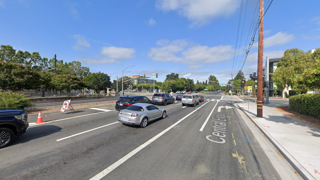

Size (256, 144) 0.2


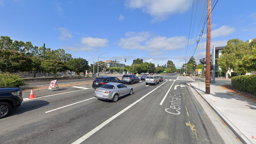

Size (230, 129) 0.18


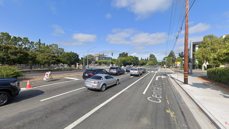

Size (192, 108) 0.15


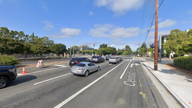

Size (166, 93) 0.13


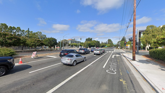

Size (128, 72) 0.1


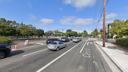

Size (102, 57) 0.08


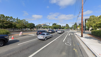

Size (64, 36) 0.05


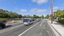

Size (38, 21) 0.03


Size (12, 7) 0.01


In [ ]:
from PIL import Image
from copy import deepcopy
test_img =Image.open("images/2023122118210235249308554587-36e8-4f15-838c-a8e2b4012184_Palo_Alto_CA_west.png")
resize_ratios = [0.25,0.2, 0.18, 0.15, 0.13, 0.1, 0.08, 0.05, 0.03, 0.01]

for ratio in resize_ratios:

    width, height = test_img.size
    new_width = int(width * ratio)
    new_height = int(height * ratio)
    new_size = (new_width, new_height)
    print("Size", new_size, ratio)
    img= deepcopy(test_img)
    img.thumbnail(new_size)
    display(img)

The aspect ratio of (256, 144) is chosen, corresponding to a downscaling of 0.2 of the original size. For smaller sizes it may become more difficult for the CNN to detect perpendicular road segments.
<br> Furthermore, the amount of pixels processed (36864) is below that of the standard ResNet (224x224 = 59536), aiding in faster training.

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!unzip /content/drive/MyDrive/Data/maps_bev.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: images_preprocessed/202312211431272963828779c989-3316-47c8-98d0-588995af64e4_Palo_Alto_CA_south.png  
  inflating: images_preprocessed/202312211431272963828779c989-3316-47c8-98d0-588995af64e4_Palo_Alto_CA_west.png  
  inflating: images_preprocessed/2023122114315023737331eb771a-4115-40bf-b7d4-859d1df60b48_Palo_Alto_CA_bev.png  
  inflating: images_preprocessed/2023122114315023737331eb771a-4115-40bf-b7d4-859d1df60b48_Palo_Alto_CA_east.png  
  inflating: images_preprocessed/2023122114315023737331eb771a-4115-40bf-b7d4-859d1df60b48_Palo_Alto_CA_grayscale.png  
  inflating: images_preprocessed/2023122114315023737331eb771a-4115-40bf-b7d4-859d1df60b48_Palo_Alto_CA_north.png  
  inflating: images_preprocessed/2023122114315023737331eb771a-4115-40bf-b7d4-859d1df60b48_Palo_Alto_CA_south.png  
  inflating: images_preprocessed/2023122114315023737331eb771a-4115-40bf-b7d4-859d1df60b48_Palo_Alto_CA_west.png  
  inflating: i

### Data Augmentation

In [4]:
import albumentations as A

from torchvision import transforms

import numpy as np
# to numpy array


a_transform = A.Compose([
    A.RandomContrast(limit=0.2),
    A.RandomGamma(),
    A.RandomBrightness(),
    A.Blur(blur_limit=2, p=0.1),

    A.RandomResizedCrop(height=144, width=256, scale=(0.95, 1.0), p=0.5),  # Random crop
    ],
    additional_targets={  # apply same transform to n, e, s, w images
        'image1': 'image',
        'image2': 'image',
        'image3': 'image',
        })

/home/amos/mambaforge/envs/bev/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/amos/mambaforge/envs/bev/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


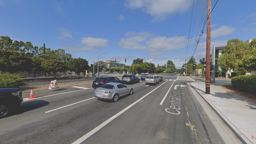

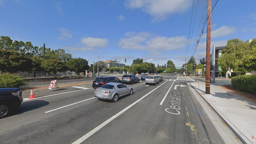

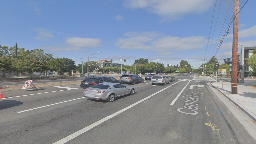

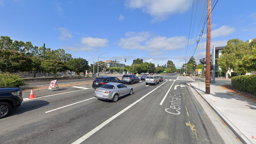

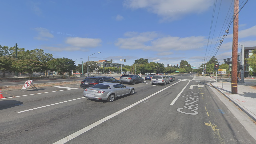

In [ ]:
test_img =Image.open("images/2023122118210235249308554587-36e8-4f15-838c-a8e2b4012184_Palo_Alto_CA_west.png")
img = np.array(test_img)
# resize the image
width, height = 256,144
for _ in range(5):
    transformed = a_transform(image=img)

    transformed_img = transforms.ToPILImage()(transformed['image'])
    transformed_img = transformed_img.resize((width, height))

    display(transformed_img)

https://github.com/AmosDinh/CNNbirdseye/blob/main/preprocess_images.py contains the preprocessing code (resizing and extraction of the binary target map)

In [5]:
# image data loader torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import random
import torch

transform_deeplabv3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class BevDataset(Dataset):
    def __init__(self, image_paths, is_training=False):

        self.img_dir = img_dir
        self.images = image_paths
        self.is_training = is_training

    def __len__(self):  # for shuffling
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        y_road = Image.open(img_path.replace('_grayscale.png', '_grayscale.png'))
        y_road = transforms.ToTensor()(y_road)
        y_road[y_road > 0] = 1
        y_noroad = torch.ones_like(y_road) - y_road
        n = Image.open(img_path.replace('_grayscale.png', '_north.png'))
        e = Image.open(img_path.replace('_grayscale.png', '_east.png'))
        s = Image.open(img_path.replace('_grayscale.png', '_south.png'))
        w = Image.open(img_path.replace('_grayscale.png', '_west.png'))

        if self.is_training:
            # apply same transform to all images
            # pil to numpy
            n = np.array(n)
            e = np.array(e)
            s = np.array(s)
            w = np.array(w)
            transformed = a_transform(image=n, image1=e, image2=s, image3=w)
            n = transformed['image']
            e = transformed['image1']
            s = transformed['image2']
            w = transformed['image3']

        n = transforms.ToTensor()(n)
        e = transforms.ToTensor()(e)
        s = transforms.ToTensor()(s)
        w = transforms.ToTensor()(w)

        y = torch.cat([y_road, y_noroad], dim=0)

        if self.is_training:
            if random.random() > 0.5:
                # flip y vertically
                y = torch.flip(y, dims=[1])
                n, s = torch.flip(s, dims=[2]), torch.flip(n, dims=[2])
                e = torch.flip(e, dims=[2]) # such that the direction is still correct
                w = torch.flip(w, dims=[2])

            if random.random() > 0.5:
                # flip y horizontally
                y = torch.flip(y, dims=[2])
                e, w = torch.flip(w, dims=[2]), torch.flip(e, dims=[2])
                n = torch.flip(n, dims=[2])
                s = torch.flip(s, dims=[2])

        return n, e, s, w, y

img_dir = 'images_preprocessed'
images = [img_dir+'/'+img for img in os.listdir(img_dir) if img.endswith('_grayscale.png')]
# sort images by name
images = sorted(images)
random.seed(14)
random.shuffle(images)
train_images = images[:int(len(images)*0.8)]
val_images = images[int(len(images)*0.8):]

# set random seed
torch.manual_seed(14)


train_dataset = BevDataset(train_images, is_training=True)
val_dataset = BevDataset(val_images, is_training=False)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4, prefetch_factor=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([3, 144, 256]) torch.Size([3, 144, 256]) torch.Size([3, 144, 256]) torch.Size([3, 144, 256]) torch.Size([2, 144, 256])


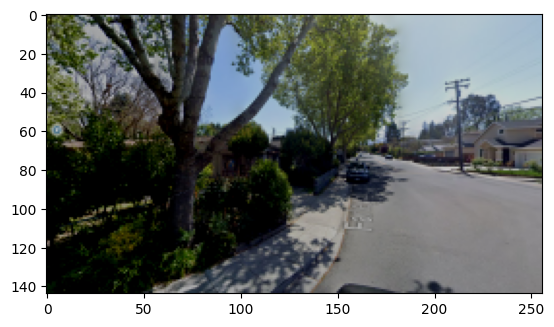

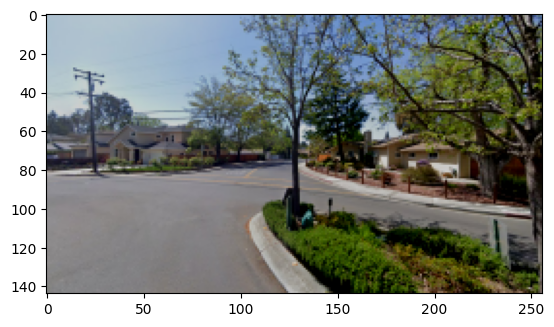

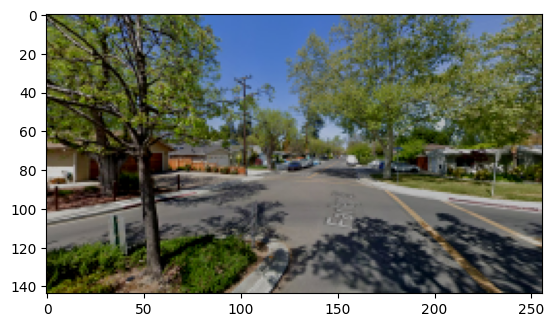

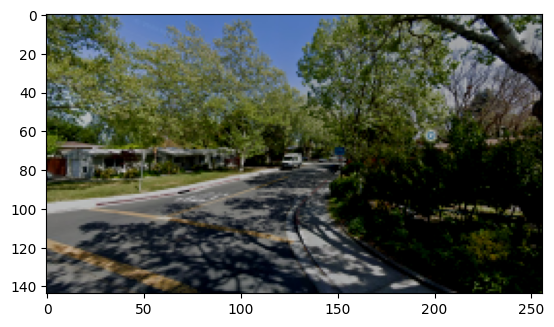

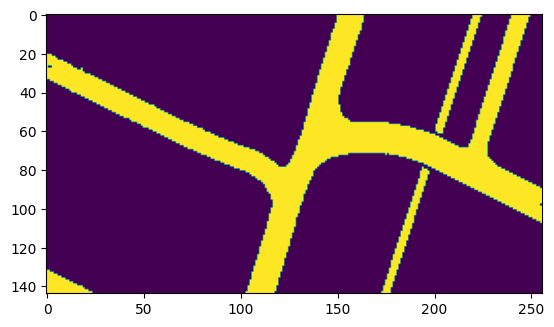

In [ ]:
n, e, s, w, y = train_dataset.__getitem__(7)
print(n.shape, e.shape, s.shape, w.shape, y.shape)

import matplotlib.pyplot as plt

def visualize(img, monochrome=False):
    if monochrome:
        plt.imshow(img)
    else:
        plt.imshow(img.permute(1,2,0))
    plt.show()

visualize(n)
visualize(e)
visualize(s)
visualize(w)
visualize(y[0],True)

The flip implementation allows for 4 variations per map.
In total 1714 (*4) images are used for training and 429 for validation.


## Visual Network

As CNN a Deeplab-V3 plus is used [4]. The network is pretrained on image segmentation tasks and serves as baseline [3] compare their model against.

It incorporates atrous convolution to preserve detail in later layers while still being able to condense the visual information[5]:
![image.png](attachment:image.png)

![image-2.png](attachment:image-2.png)
[6]

![image-3.png](attachment:image-3.png)
[6]
<br><br>
[4] https://github.com/jfzhang95/pytorch-deeplab-xception?tab=readme-ov-file<br>
[5] https://arxiv.org/abs/1802.02611<br>
[6] https://arxiv.org/abs/1706.05587

The Deeplab-V3 model has the "DeepLabHead" on top of the ResNet, as shown in the model parameters above.
The head contains the atrous spatial pyramid pooling [7]:
![image.png](attachment:image.png)

[7] https://arxiv.org/pdf/1606.00915v2.pdf

Since we want to include all four images of the street-view, the forwardpass is executed on each image separately until layer 4. In layer 4 the feature maps of all four image representations are stacked. One rescale layer between layer 3 and layer 4 is added such that the 1024*4 feature maps of the four images are reduced to 1024 feature maps, allowing the layer 4's 1024 kernels to operate on them.

For training, layers starting with layer 3 are unfrozen.

In [6]:
import torch
import torchvision
import numpy as np

class Model(torch.nn.Module):
    def __init__(self, deeplabv3) -> None:
        super().__init__()
        self.resnet = deeplabv3

        for param in self.resnet.parameters():
            param.requires_grad = False


        self.pretrained_separate1 = torch.nn.Sequential(
            self.resnet.backbone.conv1,
            self.resnet.backbone.bn1,
            self.resnet.backbone.relu,
            self.resnet.backbone.maxpool,
            self.resnet.backbone.layer1,
            #self.resnet.backbone.layer2
        )
        self.pretrained_separate_unfrezee = torch.nn.Sequential(
            self.resnet.backbone.layer2,
            self.resnet.backbone.layer3
        )
        #self.pretrained_separate_unfrezee = self.resnet.backbone.layer3

        self.rescale_1 = torch.nn.Sequential(
            torch.nn.Conv2d(4096, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False),
            torch.nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.Conv2d(2048, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False),
            torch.nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        ) # reduce the channels of all four images so it fits into layer 4

        self.pretrained_joined_unfreeze = torch.nn.Sequential(
            self.resnet.backbone.layer4,
            self.resnet.classifier[0],
            self.resnet.classifier[1],
            self.resnet.classifier[2],
            self.resnet.classifier[3],
            torch.nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1)) # road or no road
        )


        for param in self.pretrained_separate_unfrezee.parameters():
            param.requires_grad = True
        for param in self.pretrained_joined_unfreeze.parameters():
            param.requires_grad = True


    def forward(self, imgs):
        input_shape = imgs[0].shape[-2:]
        results = []
        n_imgs = imgs.shape[0]
        for i in range(n_imgs):
            x = self.pretrained_separate1(imgs[i])
            x = self.pretrained_separate_unfrezee(x)
            results.append(x)

        # concatenate along channel axis
        x = torch.cat(results, dim=1)
        x = self.rescale_1(x) # reduce the channels of all four images so it fits into layer 4
        x = self.pretrained_joined_unfreeze(x)
        x = torch.nn.functional.interpolate(x, size=input_shape, mode="bilinear", align_corners=False)
        return x


deeplabv3 = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
model = Model(deeplabv3)


n, e, s, w, y = next(iter(train_dataloader))
model_inputs = torch.stack([n,e,s,w], dim=0)
model.eval()
model_outputs = model(model_inputs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:02<00:00, 74.4MB/s]


' n, e, s, w, y = next(iter(train_dataloader))\nmodel_inputs = torch.stack([n,e,s,w], dim=0)\nmodel.eval()\nmodel_outputs = model(model_inputs) '

In [ ]:
model_inputs.shape

torch.Size([4, 2, 3, 144, 256])

In [ ]:
model_outputs.shape

torch.Size([32, 2, 144, 256])

## Loss function
As loss function Cross-Entropy loss is employed. Further, a loss mask is applied, which weighs the loss at the center of the BEV map higher:
Often, from the street-view, it is impossible to determine adjacent roads, which are visible in the BEV.

1.  The approach of using a loss mask is adopted because the outer part of the BEV might still contain useful supervision information.




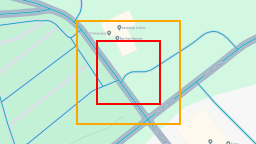

In [7]:
from PIL import Image, ImageDraw
import torch
resize_width = 256
resize_height = 144

image_path = 'images_preprocessed/2023122117182785646831757876-c500-4fb0-a2ff-f60fc8e34896_Palo_Alto_CA_bev.png'
img = Image.open(image_path).convert('RGB')
# resize
img = img.resize((resize_width, resize_height), Image.BILINEAR)

inner_box = (96,40, 160, 104)
middle_box = (76, 20, 180, 124)
# draw rectangle with inner box
draw = ImageDraw.Draw(img)
draw.rectangle(inner_box, outline='red', width=2)
draw.rectangle(middle_box, outline='orange', width=2)
display(img)

outer_penalty = 0.05
middle_penalty = 0.5
inner_penalty = 1

loss_mask = torch.ones((resize_height, resize_width)) * outer_penalty
loss_mask[middle_box[1]:middle_box[3], middle_box[0]:middle_box[2]] = middle_penalty
loss_mask[inner_box[1]:inner_box[3], inner_box[0]:inner_box[2]] = inner_penalty

In [8]:
def criterion(pred, target, loss_mask):
    loss = torch.nn.functional.cross_entropy(pred, target, reduction='none')
    loss = torch.multiply(loss, loss_mask) # apply the mask, weighting loss in different regions differently
    return loss.mean()

## Training

In [ ]:
from tqdm.auto import tqdm
torch.cuda.empty_cache()
import gc
gc.collect()

model.cuda()
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_mask = loss_mask.cuda()
losses = []
for epoch in range(0,400):
    for i, (n, e, s, w, y) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        model_inputs = torch.stack([n,e,s,w], dim=0)
        model_outputs = model(model_inputs.cuda())
        loss = criterion(model_outputs, y.cuda(), loss_mask)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        tqdm.write('loss ' + str(loss.item()))
        losses.append(loss.item())

    if epoch % 10 ==0:
        save_path = f'/content/drive/MyDrive/Data/maps_bev_models/model_checkpoint_{epoch}.pth'
        # Create a dictionary to store model state dictionary and optimizer state
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }
        torch.save(checkpoint, save_path)
        torch.save({'loss':losses}, '/content/drive/MyDrive/Data/maps_bev_models/loss.pt')

    print("Epoch", epoch, "Loss", loss.item())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.15098442137241364
loss 0.14886702597141266
loss 0.15096525847911835
loss 0.14592190086841583
loss 0.14409363269805908
loss 0.14074093103408813
loss 0.13763408362865448
loss 0.15079718828201294
loss 0.14485545456409454
loss 0.136890709400177
loss 0.1348707675933838
loss 0.13891297578811646
loss 0.1429031938314438
loss 0.13934911787509918
loss 0.139726459980011
loss 0.14219024777412415
loss 0.1364716738462448
loss 0.13725405931472778
loss 0.134456604719162
loss 0.1428825855255127
loss 0.14030678570270538
loss 0.1350649744272232
loss 0.1381932497024536
loss 0.1309569776058197
loss 0.13809849321842194
loss 0.13098862767219543
loss 0.12783648073673248
loss 0.13683901727199554
loss 0.13557446002960205
loss 0.13469389081001282
loss 0.136601522564888
loss 0.13401587307453156
loss 0.13120491802692413
loss 0.13456495106220245
loss 0.13194604218006134
loss 0.13377279043197632
loss 0.13578349351882935
loss 0.12988612055778503
loss 0.12726211547851562
loss 0.13164038956165314
loss 0.12835125

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.12123039364814758
loss 0.13553400337696075
loss 0.11916245520114899
loss 0.1272001564502716
loss 0.1259639859199524
loss 0.13096031546592712
loss 0.1195199266076088
loss 0.12044135481119156
loss 0.12265988439321518
loss 0.1141626313328743
loss 0.1149103119969368
loss 0.11037982255220413
loss 0.11680076271295547
loss 0.12243381887674332
loss 0.11484578996896744
loss 0.12656283378601074
loss 0.12102723121643066
loss 0.13662931323051453
loss 0.12805604934692383
loss 0.10966857522726059
loss 0.12791651487350464
loss 0.12797066569328308
loss 0.12156160920858383
loss 0.11059115827083588
loss 0.1075921505689621
loss 0.11514941602945328
loss 0.1351083368062973
loss 0.1244734674692154
loss 0.1214393675327301
loss 0.12482474744319916
loss 0.11328204721212387
loss 0.11640501022338867
loss 0.12698446214199066
loss 0.11984210461378098
loss 0.11813192814588547
loss 0.11981839686632156
loss 0.10890839248895645
loss 0.11735333502292633
loss 0.1167897954583168
loss 0.12796445190906525
loss 0.112

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.10611823946237564
loss 0.10425243526697159
loss 0.1152317002415657
loss 0.1109338030219078
loss 0.10071680694818497
loss 0.11074136197566986
loss 0.11067277193069458
loss 0.1102844625711441
loss 0.10786695033311844
loss 0.11221037060022354
loss 0.11045665293931961
loss 0.1136138066649437
loss 0.104930080473423
loss 0.1183079332113266
loss 0.10979175567626953
loss 0.10318614542484283
loss 0.11350766569375992
loss 0.10765568166971207
loss 0.10595959424972534
loss 0.1065155416727066
loss 0.10337057709693909
loss 0.11084047704935074
loss 0.12321349233388901
loss 0.10878169536590576
loss 0.10329963266849518
loss 0.1143903061747551
loss 0.11446460336446762
loss 0.09976652264595032
loss 0.10986438393592834
loss 0.11134759336709976
loss 0.10753508657217026
loss 0.10953354835510254
loss 0.10920189321041107
loss 0.11768797785043716
loss 0.10542643815279007
loss 0.10437295585870743
loss 0.104598768055439
loss 0.10048238188028336
loss 0.10610614717006683
loss 0.11197812110185623
loss 0.1058

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.10587888211011887
loss 0.10811243206262589
loss 0.09227923303842545
loss 0.11154209077358246
loss 0.10595040023326874
loss 0.10498007386922836
loss 0.10338413715362549
loss 0.09542106837034225
loss 0.10009143501520157
loss 0.10007792711257935
loss 0.1087031364440918
loss 0.0987737700343132
loss 0.10071781277656555
loss 0.10251936316490173
loss 0.11117153614759445
loss 0.10212802141904831
loss 0.10968655347824097
loss 0.10618424415588379
loss 0.10333091765642166
loss 0.11078651994466782
loss 0.10508004575967789
loss 0.10606444627046585
loss 0.1031658872961998
loss 0.10303298383951187
loss 0.10399230569601059
loss 0.10186705738306046
loss 0.11154699325561523
loss 0.09292999655008316
loss 0.1009085401892662
loss 0.1029835119843483
loss 0.09576179087162018
loss 0.1031167283654213
loss 0.10723075270652771
loss 0.10932695120573044
loss 0.11257394403219223
loss 0.11216868460178375
loss 0.11070652306079865
loss 0.10155893117189407
loss 0.10263053327798843
loss 0.11234150826931
loss 0.09

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.09440204501152039
loss 0.11553002893924713
loss 0.10905959457159042
loss 0.107615165412426
loss 0.09459229558706284
loss 0.10650903731584549
loss 0.10172943025827408
loss 0.09767035394906998
loss 0.09259673207998276
loss 0.10485448688268661
loss 0.09263933449983597
loss 0.09552792459726334
loss 0.08981510996818542
loss 0.09585392475128174
loss 0.09179418534040451
loss 0.1004728451371193
loss 0.11297313123941422
loss 0.09709078818559647
loss 0.11626548320055008
loss 0.09393950551748276
loss 0.10097608715295792
loss 0.10142172873020172
loss 0.09071769565343857
loss 0.0954970195889473
loss 0.09546384960412979
loss 0.08278114348649979
loss 0.09487584978342056
loss 0.09905338287353516
loss 0.1071605309844017
loss 0.09619364887475967
loss 0.09268245846033096
loss 0.1002746969461441
loss 0.1067144051194191
loss 0.09211520105600357
loss 0.10154473036527634
loss 0.09679868817329407
loss 0.09436562657356262
loss 0.08766809850931168
loss 0.0986623466014862
loss 0.1026044711470604
loss 0.09

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.09542311728000641
loss 0.0961223840713501
loss 0.10421208292245865
loss 0.08887581527233124
loss 0.10387635231018066
loss 0.08855349570512772
loss 0.0926564484834671
loss 0.10346778482198715
loss 0.09163767844438553
loss 0.10716716200113297
loss 0.08971524238586426
loss 0.104679174721241
loss 0.09681897610425949
loss 0.09440929442644119
loss 0.09226624667644501
loss 0.1061858981847763
loss 0.09517218917608261
loss 0.08708345890045166
loss 0.09686479717493057
loss 0.09878408163785934
loss 0.10167078673839569
loss 0.09577964246273041
loss 0.09061387926340103
loss 0.0937727615237236
loss 0.10020266473293304
loss 0.0973995104432106
loss 0.09293022751808167
loss 0.09407702088356018
loss 0.10177604109048843
loss 0.0962769091129303
loss 0.0968329980969429
loss 0.09603407979011536
loss 0.09797743707895279
loss 0.09977994859218597
loss 0.08908399194478989
loss 0.09722349792718887
loss 0.09776140004396439
loss 0.09384653717279434
loss 0.08936820179224014
loss 0.08392250537872314
loss 0.10

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.09363272786140442
loss 0.0986718237400055
loss 0.08965843170881271
loss 0.0869273915886879
loss 0.09099727869033813
loss 0.08093317598104477
loss 0.08786124736070633
loss 0.09643382579088211
loss 0.09561667591333389
loss 0.0881146565079689
loss 0.0929175317287445
loss 0.10185815393924713
loss 0.08959370106458664
loss 0.08736173808574677
loss 0.09814635664224625
loss 0.08864782005548477
loss 0.08601473271846771
loss 0.08731022477149963
loss 0.0838426873087883
loss 0.09630740433931351
loss 0.0864715501666069
loss 0.09193935990333557
loss 0.09132950752973557
loss 0.08955498784780502
loss 0.08838146179914474
loss 0.09573862701654434
loss 0.09446372091770172
loss 0.0907152071595192
loss 0.09211714565753937
loss 0.08259209245443344
loss 0.08095934987068176
loss 0.09787703305482864
loss 0.08835168927907944
loss 0.08926369994878769
loss 0.09284286946058273
loss 0.1019129604101181
loss 0.09305363893508911
loss 0.08694623410701752
loss 0.08397284150123596
loss 0.09455222636461258
loss 0.0

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.09848390519618988
loss 0.09570286422967911
loss 0.08766023069620132
loss 0.08514422923326492
loss 0.08818411082029343
loss 0.08597812801599503
loss 0.09443912655115128
loss 0.0989471822977066
loss 0.08532571792602539
loss 0.09150516986846924
loss 0.08904386311769485
loss 0.08789866417646408
loss 0.09495514631271362
loss 0.09527400135993958
loss 0.09710144996643066
loss 0.08055488765239716
loss 0.08073809742927551
loss 0.082678884267807
loss 0.0889967530965805
loss 0.0956796184182167
loss 0.09899379312992096
loss 0.0815499797463417
loss 0.08834884315729141
loss 0.08282867819070816
loss 0.08758143335580826
loss 0.09205496311187744
loss 0.0853796899318695
loss 0.09193902462720871
loss 0.07912003248929977
loss 0.08927878737449646
loss 0.08956924080848694
loss 0.08460543304681778
loss 0.10257119685411453
loss 0.09073252230882645
loss 0.09171818196773529
loss 0.08960747718811035
loss 0.08004728704690933
loss 0.08676479756832123
loss 0.09447524696588516
loss 0.08482495695352554
loss 0.

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.08437852561473846
loss 0.07738678902387619
loss 0.0757717564702034
loss 0.09210669994354248
loss 0.08398998528718948
loss 0.09541300684213638
loss 0.08162486553192139
loss 0.07807847857475281
loss 0.09313048422336578
loss 0.09238845854997635
loss 0.08229608088731766
loss 0.08384110778570175
loss 0.09096067398786545
loss 0.08368349075317383
loss 0.09634526073932648
loss 0.09084881842136383
loss 0.0852733701467514
loss 0.08659064024686813
loss 0.09775197505950928
loss 0.0830131396651268
loss 0.09151344746351242
loss 0.09013961255550385
loss 0.088340163230896
loss 0.08442607522010803
loss 0.0820562094449997
loss 0.08027153462171555
loss 0.08367558568716049
loss 0.07876227051019669
loss 0.08711337298154831
loss 0.08442170172929764
loss 0.07762014865875244
loss 0.08371177315711975
loss 0.08749830722808838
loss 0.08651963621377945
loss 0.08359725028276443
loss 0.08187581598758698
loss 0.081893190741539
loss 0.0841655507683754
loss 0.08517917990684509
loss 0.08426252752542496
loss 0.08

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.07999388128519058
loss 0.08864429593086243
loss 0.09055645763874054
loss 0.08663198351860046
loss 0.08560232818126678
loss 0.08526933193206787
loss 0.08083076030015945
loss 0.08690524101257324
loss 0.07906381040811539
loss 0.0838443860411644
loss 0.08739747107028961
loss 0.07472456246614456
loss 0.08669544756412506
loss 0.09113488346338272
loss 0.08885696530342102
loss 0.08130541443824768
loss 0.10019221901893616
loss 0.08137966692447662
loss 0.07470269501209259
loss 0.08596514165401459
loss 0.08225810527801514
loss 0.08486379683017731
loss 0.08365005999803543
loss 0.08726601302623749
loss 0.08201314508914948
loss 0.08044639974832535
loss 0.07607372105121613
loss 0.08028782904148102
loss 0.08477159589529037
loss 0.08741138130426407
loss 0.09250737726688385
loss 0.08459816873073578
loss 0.07836724817752838
loss 0.08609233796596527
loss 0.07547618448734283
loss 0.08089663088321686
loss 0.09020975977182388
loss 0.08218320459127426
loss 0.08512631803750992
loss 0.08508198708295822
l

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.08417149633169174
loss 0.07889793068170547
loss 0.08819319307804108
loss 0.09563896805047989
loss 0.08469932526350021
loss 0.0734846442937851
loss 0.09132696688175201
loss 0.08542977273464203
loss 0.08514359593391418
loss 0.0809854194521904
loss 0.0862034261226654
loss 0.08446548134088516
loss 0.08445952087640762
loss 0.08630929887294769
loss 0.08277879655361176
loss 0.08460736274719238
loss 0.08113481849431992
loss 0.07831679284572601
loss 0.08664796501398087
loss 0.07451105862855911
loss 0.08300784230232239
loss 0.08539509773254395
loss 0.07943752408027649
loss 0.08520969748497009
loss 0.08077912777662277
loss 0.07705418020486832
loss 0.08743030577898026
loss 0.07221073657274246
loss 0.08037466555833817
loss 0.08598262816667557
loss 0.07882162183523178
loss 0.0783572793006897
loss 0.09772387146949768
loss 0.07778171449899673
loss 0.07870185375213623
loss 0.0850842073559761
loss 0.07339449971914291
loss 0.07266279309988022
loss 0.0751902312040329
loss 0.0821569636464119
loss 0.

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.08460543304681778
loss 0.07779429107904434
loss 0.07999350875616074
loss 0.0796424001455307
loss 0.07979859411716461
loss 0.08119281381368637
loss 0.07684320956468582
loss 0.0762597918510437
loss 0.0862903743982315
loss 0.08360759168863297
loss 0.08291221410036087
loss 0.08120056986808777
loss 0.08456211537122726
loss 0.07888410985469818
loss 0.07452388852834702
loss 0.07706348598003387
loss 0.07106755673885345
loss 0.07756156474351883
loss 0.08767423778772354
loss 0.07388239353895187
loss 0.07399996370077133
loss 0.08348041772842407
loss 0.0774395763874054
loss 0.07913798838853836
loss 0.07837208360433578
loss 0.07804519683122635
loss 0.07860157638788223
loss 0.07702258974313736
loss 0.08195412158966064
loss 0.07367401570081711
loss 0.08078600466251373
loss 0.0785137340426445
loss 0.0911441221833229
loss 0.0884699821472168
loss 0.07762447744607925
loss 0.08493288606405258
loss 0.07471194118261337
loss 0.08250962197780609
loss 0.07217008620500565
loss 0.08518539369106293
loss 0.

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.07432571053504944
loss 0.07325246185064316
loss 0.07974069565534592
loss 0.08235567063093185
loss 0.07541932165622711
loss 0.07322075963020325
loss 0.08598820120096207
loss 0.08343398571014404
loss 0.07610712200403214
loss 0.07975025475025177
loss 0.08208414167165756
loss 0.08088307827711105
loss 0.08477286994457245
loss 0.08354560285806656
loss 0.07708074152469635
loss 0.07927262037992477
loss 0.08803095668554306
loss 0.08070526272058487
loss 0.0753953605890274
loss 0.06822506338357925
loss 0.0708385482430458
loss 0.08033505827188492
loss 0.07951513677835464
loss 0.08158665150403976
loss 0.07839425653219223
loss 0.08193112909793854
loss 0.0873495563864708
loss 0.08028631657361984
loss 0.07589725404977798
loss 0.08379250019788742
loss 0.07123981416225433
loss 0.08083508163690567
loss 0.08594466745853424
loss 0.08353490382432938
loss 0.07962122559547424
loss 0.08363815397024155
loss 0.07559511810541153
loss 0.08345619589090347
loss 0.06976864486932755
loss 0.07772714644670486
los

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.08007512986660004
loss 0.07494150102138519
loss 0.08321169763803482
loss 0.07552773505449295
loss 0.06792602688074112
loss 0.08402680605649948
loss 0.07040543854236603
loss 0.07470140606164932
loss 0.08766136318445206
loss 0.07242704927921295
loss 0.0737331211566925
loss 0.07775603979825974
loss 0.08269480615854263
loss 0.07194100320339203
loss 0.08113956451416016
loss 0.0803699940443039
loss 0.07194986194372177
loss 0.07964418083429337
loss 0.07691362500190735
loss 0.07594463229179382
loss 0.06875018030405045
loss 0.07070398330688477
loss 0.07458173483610153
loss 0.08568926900625229
loss 0.07015480101108551
loss 0.08087126165628433
loss 0.07793182879686356
loss 0.08485452830791473
loss 0.0689532533288002
loss 0.08620043843984604
loss 0.07729710638523102
loss 0.0791763961315155
loss 0.0768619030714035
loss 0.07574161142110825
loss 0.07751365005970001
loss 0.07677993178367615
loss 0.075966477394104
loss 0.07187076658010483
loss 0.07255325466394424
loss 0.07597573101520538
loss 0.

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.07421018183231354
loss 0.07344506680965424
loss 0.07392927259206772
loss 0.0817520022392273
loss 0.07340281456708908
loss 0.07489972561597824
loss 0.0846124067902565
loss 0.0762464851140976
loss 0.06899739801883698
loss 0.07487814128398895
loss 0.08016251772642136
loss 0.07042136788368225
loss 0.07776709645986557
loss 0.07215148955583572
loss 0.0809355303645134
loss 0.06871522963047028
loss 0.08196712285280228
loss 0.0721132829785347
loss 0.0809243842959404
loss 0.07175961881875992
loss 0.07556049525737762
loss 0.07356134057044983
loss 0.07314859330654144
loss 0.073440320789814
loss 0.0750836506485939
loss 0.0826290175318718
loss 0.08245698362588882
loss 0.07697154581546783
loss 0.07142871618270874
loss 0.07141135632991791
loss 0.07317817211151123
loss 0.07857819646596909
loss 0.07457608729600906
loss 0.07266038656234741
loss 0.07557056099176407
loss 0.08093301206827164
loss 0.07029265910387039
loss 0.07926150411367416
loss 0.08945146948099136
loss 0.07720935344696045
loss 0.080

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.063128761947155
loss 0.07893171906471252
loss 0.07183410227298737
loss 0.07085176557302475
loss 0.07624372094869614
loss 0.07000495493412018
loss 0.06501153111457825
loss 0.0766330435872078
loss 0.07208621501922607
loss 0.07653192430734634
loss 0.07350226491689682
loss 0.0781155601143837
loss 0.0689588189125061
loss 0.06835100054740906
loss 0.07959309220314026
loss 0.08240041136741638
loss 0.07863584905862808
loss 0.07298891991376877
loss 0.07844185829162598
loss 0.07171722501516342
loss 0.06942097097635269
loss 0.07500149309635162
loss 0.0818367600440979
loss 0.08897839486598969
loss 0.07728572934865952
loss 0.06899702548980713
loss 0.07670757174491882
loss 0.07327987998723984
loss 0.08027946203947067
loss 0.07697953283786774
loss 0.07250559329986572
loss 0.0734051838517189
loss 0.08428280055522919
loss 0.06776592880487442
loss 0.0696558952331543
loss 0.07081743329763412
loss 0.074590303003788
loss 0.0718383938074112
loss 0.07033687829971313
loss 0.0752052441239357
loss 0.06744

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.0669134110212326
loss 0.06835003942251205
loss 0.07016342878341675
loss 0.08641598373651505
loss 0.07128928601741791
loss 0.06816461682319641
loss 0.07113169878721237
loss 0.07374744862318039
loss 0.07082560658454895
loss 0.07832392305135727
loss 0.07853765040636063
loss 0.06891262531280518
loss 0.0717303454875946
loss 0.07613207399845123
loss 0.061535485088825226
loss 0.07342153042554855
loss 0.07540541142225266
loss 0.06702015548944473
loss 0.07135677337646484
loss 0.07038449496030807
loss 0.08196938782930374
loss 0.08702843636274338
loss 0.07423511892557144
loss 0.0784175768494606
loss 0.07967127859592438
loss 0.06646672636270523
loss 0.06977959722280502
loss 0.07030756026506424
loss 0.07272956520318985
loss 0.0772751048207283
loss 0.07941002398729324
loss 0.0714545026421547
loss 0.07230180501937866
loss 0.07574459165334702
loss 0.06632252782583237
loss 0.06117849797010422
loss 0.07083633542060852
loss 0.0739041343331337
loss 0.06419859826564789
loss 0.07809668034315109
loss 

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.0713072121143341
loss 0.0697692409157753
loss 0.07525253295898438
loss 0.06726042181253433
loss 0.07059362530708313
loss 0.06396490335464478
loss 0.08307541161775589
loss 0.07463977485895157
loss 0.07770625501871109
loss 0.06520280987024307
loss 0.07591190934181213
loss 0.0786634162068367
loss 0.07253406196832657
loss 0.07088793814182281
loss 0.06898757070302963
loss 0.07456735521554947
loss 0.073713518679142
loss 0.07109788805246353
loss 0.07824364304542542
loss 0.06879051774740219
loss 0.06518447399139404
loss 0.06741376221179962
loss 0.07036559283733368
loss 0.06929772347211838
loss 0.07149136066436768
loss 0.07003001123666763
loss 0.07492440938949585
loss 0.06985808908939362
loss 0.07593928277492523
loss 0.06824145466089249
loss 0.06893465667963028
loss 0.08681759983301163
loss 0.07178298383951187
loss 0.06962466984987259
loss 0.06589075177907944
loss 0.07361515611410141
loss 0.06902100890874863
loss 0.07208486646413803
loss 0.06904499977827072
loss 0.07193679362535477
loss 

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.07098004221916199
loss 0.06550643593072891
loss 0.07824099063873291
loss 0.07540398091077805
loss 0.06422590464353561
loss 0.06981231272220612
loss 0.07028350234031677
loss 0.0683978945016861
loss 0.06913401186466217
loss 0.06616095453500748
loss 0.06322354823350906
loss 0.06859389692544937
loss 0.06962912529706955
loss 0.0731230080127716
loss 0.075933538377285
loss 0.07708797603845596
loss 0.07176560908555984
loss 0.07376716285943985
loss 0.07590138167142868
loss 0.07004401832818985
loss 0.07820011675357819
loss 0.06235665827989578
loss 0.07455519586801529
loss 0.06742478907108307
loss 0.062063708901405334
loss 0.06810792535543442
loss 0.07470546662807465
loss 0.0623239167034626
loss 0.06399797648191452
loss 0.06691095978021622
loss 0.07106070220470428
loss 0.07927866280078888
loss 0.07128050923347473
loss 0.07155970484018326
loss 0.06709075719118118
loss 0.0632190853357315
loss 0.07178281247615814
loss 0.07541642338037491
loss 0.06999819725751877
loss 0.0744229257106781
loss 0

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.07543088495731354
loss 0.07466839998960495
loss 0.0714339166879654
loss 0.06803931295871735
loss 0.06554170697927475
loss 0.07880270481109619
loss 0.0643041580915451
loss 0.07566041499376297
loss 0.057871390134096146
loss 0.07284440100193024
loss 0.07542528212070465
loss 0.07232987880706787
loss 0.0688186064362526
loss 0.06874723732471466
loss 0.06465236842632294
loss 0.06854045391082764
loss 0.06877456605434418
loss 0.07672124356031418
loss 0.06598131358623505
loss 0.06235875189304352
loss 0.059843797236680984
loss 0.062325067818164825
loss 0.07329189777374268
loss 0.0734204649925232
loss 0.06787264347076416
loss 0.06413675844669342
loss 0.0693449005484581
loss 0.06722547113895416
loss 0.06903395801782608
loss 0.06380455195903778
loss 0.06276892125606537
loss 0.06445835530757904
loss 0.0688861683011055
loss 0.06578873097896576
loss 0.07347900420427322
loss 0.07814084738492966
loss 0.07060287147760391
loss 0.06925385445356369
loss 0.06486169993877411
loss 0.07535580545663834
los

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.06633711606264114
loss 0.06482933461666107
loss 0.06534765660762787
loss 0.07539262622594833
loss 0.06836054474115372
loss 0.07623737305402756
loss 0.06625648587942123
loss 0.06899946928024292
loss 0.07608401030302048
loss 0.05806705728173256
loss 0.06608833372592926
loss 0.07016374915838242
loss 0.06687001138925552
loss 0.061610203236341476
loss 0.06829515844583511
loss 0.06859863549470901
loss 0.06715191155672073
loss 0.07053780555725098
loss 0.06491260975599289
loss 0.058262575417757034
loss 0.07524941861629486
loss 0.07467924058437347
loss 0.07810775190591812
loss 0.06428469717502594
loss 0.05960269272327423
loss 0.07628283649682999
loss 0.06662999838590622
loss 0.06833396106958389
loss 0.06589910387992859
loss 0.06001455336809158
loss 0.07416907697916031
loss 0.07093380391597748
loss 0.061610858887434006
loss 0.07060980051755905
loss 0.07256023585796356
loss 0.07518911361694336
loss 0.07025889307260513
loss 0.06259489059448242
loss 0.06704334169626236
loss 0.067039400339126

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.0633089542388916
loss 0.057503752410411835
loss 0.062107402831315994
loss 0.06702462583780289
loss 0.0690898448228836
loss 0.06559089571237564
loss 0.0669301301240921
loss 0.062140412628650665
loss 0.07027915865182877
loss 0.06334767490625381
loss 0.0744999423623085
loss 0.06899704784154892
loss 0.06923004239797592
loss 0.05964048579335213
loss 0.06612758338451385
loss 0.06792061775922775
loss 0.06319057941436768
loss 0.06259242445230484
loss 0.06633710861206055
loss 0.06523448973894119
loss 0.06105823069810867
loss 0.07156496495008469
loss 0.0639791339635849
loss 0.06427367776632309
loss 0.0730489045381546
loss 0.06925593316555023
loss 0.06661452353000641
loss 0.06463993340730667
loss 0.06801711022853851
loss 0.07849273085594177
loss 0.0661977007985115
loss 0.06635577231645584
loss 0.06413083523511887
loss 0.07550768554210663
loss 0.06568785011768341
loss 0.07239037752151489
loss 0.06197696179151535
loss 0.06555970758199692
loss 0.06358721852302551
loss 0.07704330235719681
loss

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.06292353570461273
loss 0.06557878851890564
loss 0.06811357289552689
loss 0.06327153742313385
loss 0.06886525452136993
loss 0.07088875025510788
loss 0.06043342128396034
loss 0.07501178234815598
loss 0.06503664702177048
loss 0.06554266810417175
loss 0.06800632923841476
loss 0.07217139005661011
loss 0.06317654252052307
loss 0.06174333766102791
loss 0.07587312161922455
loss 0.0654710903763771
loss 0.06603843718767166
loss 0.07170175015926361
loss 0.059762172400951385
loss 0.06147521734237671
loss 0.058010924607515335
loss 0.06865274906158447
loss 0.07868585735559464
loss 0.07312522083520889
loss 0.06856022775173187
loss 0.0709214136004448
loss 0.06917160004377365
loss 0.06539364904165268
loss 0.06822358816862106
loss 0.07183613628149033
loss 0.06411201506853104
loss 0.06431738287210464
loss 0.07328364253044128
loss 0.061950426548719406
loss 0.058452147990465164
loss 0.06696656346321106
loss 0.06603895872831345
loss 0.06316549330949783
loss 0.06045695021748543
loss 0.0686073079705238

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.06169101968407631
loss 0.06415889412164688
loss 0.06814330816268921
loss 0.0665614977478981
loss 0.07299738377332687
loss 0.061784785240888596
loss 0.06938035041093826
loss 0.06708236783742905
loss 0.073114775121212
loss 0.06213173642754555
loss 0.0677911713719368
loss 0.06920284032821655
loss 0.06503711640834808
loss 0.07568754255771637
loss 0.0670386329293251
loss 0.0628909319639206
loss 0.06806329637765884
loss 0.06627726554870605
loss 0.06719333678483963
loss 0.07248761504888535
loss 0.06424430757761002
loss 0.06415652483701706
loss 0.06350048631429672
loss 0.06392379850149155
loss 0.06402860581874847
loss 0.06361252814531326
loss 0.060783181339502335
loss 0.07123858481645584
loss 0.07046232372522354
loss 0.06751782447099686
loss 0.0650762990117073
loss 0.07244274765253067
loss 0.07258956879377365
loss 0.06914541870355606
loss 0.05853473022580147
loss 0.06036233901977539
loss 0.0647037997841835
loss 0.06207064166665077
loss 0.06753413379192352
loss 0.06729593127965927
loss 0

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.06622448563575745
loss 0.06289544701576233
loss 0.06989996880292892
loss 0.07304389029741287
loss 0.06410058587789536
loss 0.06469575315713882
loss 0.0674455538392067
loss 0.06235172972083092
loss 0.06602521240711212
loss 0.062106888741254807
loss 0.05978919565677643
loss 0.059498097747564316
loss 0.06333740055561066
loss 0.06799916177988052
loss 0.05707542225718498
loss 0.06364081054925919
loss 0.06567075848579407
loss 0.07679376751184464
loss 0.05867253616452217
loss 0.06789349764585495
loss 0.06662631779909134
loss 0.05872330442070961
loss 0.062413886189460754
loss 0.06414256989955902
loss 0.06702827662229538
loss 0.060764867812395096
loss 0.05690979212522507
loss 0.06580834835767746
loss 0.07672113925218582
loss 0.06485757976770401
loss 0.0626465454697609
loss 0.06478632986545563
loss 0.059614989906549454
loss 0.057883117347955704
loss 0.06402646750211716
loss 0.0589444637298584
loss 0.059807904064655304
loss 0.06684500724077225
loss 0.06096458435058594
loss 0.06297568231821

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.05864225700497627
loss 0.056784458458423615
loss 0.055875375866889954
loss 0.06791744381189346
loss 0.06177626922726631
loss 0.06293388456106186
loss 0.05654006078839302
loss 0.06769445538520813
loss 0.0650951936841011
loss 0.05662985146045685
loss 0.06906162202358246
loss 0.06686542183160782
loss 0.05499076843261719
loss 0.060593944042921066
loss 0.06344246864318848
loss 0.06083260849118233
loss 0.06401196867227554
loss 0.06028888747096062
loss 0.051819104701280594
loss 0.06428895890712738
loss 0.07134541124105453
loss 0.05844692513346672
loss 0.05971294641494751
loss 0.06066514551639557
loss 0.06320362538099289
loss 0.061251819133758545
loss 0.067818284034729
loss 0.07184968888759613
loss 0.06496324390172958
loss 0.06239716336131096
loss 0.06306593865156174
loss 0.059579651802778244
loss 0.06896381080150604
loss 0.05962223559617996
loss 0.0653689056634903
loss 0.06130768731236458
loss 0.06254632771015167
loss 0.0669386237859726
loss 0.06180115044116974
loss 0.06538405269384384

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.06036486104130745
loss 0.06279448419809341
loss 0.0641503855586052
loss 0.05841587856411934
loss 0.05879150703549385
loss 0.06367772072553635
loss 0.06966415047645569
loss 0.062172796577215195
loss 0.05793048441410065
loss 0.06982376426458359
loss 0.06995712965726852
loss 0.05697711184620857
loss 0.06014202907681465
loss 0.058380842208862305
loss 0.06186317652463913
loss 0.06837593019008636
loss 0.062121059745550156
loss 0.06115897372364998
loss 0.06199945509433746
loss 0.06322897225618362
loss 0.057765014469623566
loss 0.06186366081237793
loss 0.0653543472290039
loss 0.06007859483361244
loss 0.062045659869909286
loss 0.06527295708656311
loss 0.0617392472922802
loss 0.06579695641994476
loss 0.05469410866498947
loss 0.05489521473646164
loss 0.05563826858997345
loss 0.06911587715148926
loss 0.05593954399228096
loss 0.07020624727010727
loss 0.06431294977664948
loss 0.0631469115614891
loss 0.05929827690124512
loss 0.06147205829620361
loss 0.05850014463067055
loss 0.05198955163359642

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.04931645840406418
loss 0.06101846694946289
loss 0.06035804748535156
loss 0.06842119246721268
loss 0.06617508828639984
loss 0.061200909316539764
loss 0.057538047432899475
loss 0.05458255484700203
loss 0.05540776625275612
loss 0.06604716926813126
loss 0.056924156844615936
loss 0.06872023642063141
loss 0.05792819336056709
loss 0.06504368036985397
loss 0.06319638341665268
loss 0.07016942650079727
loss 0.054753758013248444
loss 0.06274235248565674
loss 0.06596691161394119
loss 0.05653687193989754
loss 0.06116194278001785
loss 0.0677599087357521
loss 0.07004722207784653
loss 0.06864995509386063
loss 0.06999123096466064
loss 0.05937184393405914
loss 0.06183495745062828
loss 0.0607006698846817
loss 0.06783755868673325
loss 0.06369009613990784
loss 0.06190938502550125
loss 0.05661555007100105
loss 0.0613352470099926
loss 0.06196304038167
loss 0.0637490525841713
loss 0.0710294246673584
loss 0.06312254816293716
loss 0.06784217804670334
loss 0.05541083961725235
loss 0.0671704038977623
loss 

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.06424602121114731
loss 0.060403693467378616
loss 0.07052258402109146
loss 0.06086745485663414
loss 0.057739630341529846
loss 0.061456192284822464
loss 0.060507554560899734
loss 0.06341421604156494
loss 0.05813378095626831
loss 0.05981232598423958
loss 0.061542630195617676
loss 0.061267536133527756
loss 0.0541280172765255
loss 0.06652134656906128
loss 0.060455322265625
loss 0.06740598380565643
loss 0.0540304072201252
loss 0.06289977580308914
loss 0.06827190518379211
loss 0.06405043601989746
loss 0.05779683589935303
loss 0.064540334045887
loss 0.060980089008808136
loss 0.061294395476579666
loss 0.059642963111400604
loss 0.05482878163456917
loss 0.056430380791425705
loss 0.06262101233005524
loss 0.06515707075595856
loss 0.058024752885103226
loss 0.06018328666687012
loss 0.06570842862129211
loss 0.06261871010065079
loss 0.0602908618748188
loss 0.05457702651619911
loss 0.05781450495123863
loss 0.06936009973287582
loss 0.06265739351511002
loss 0.055630166083574295
loss 0.0628457069396

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.05999518930912018
loss 0.05844569206237793
loss 0.055563636124134064
loss 0.061782825738191605
loss 0.057906124740839005
loss 0.0573403425514698
loss 0.05825447291135788
loss 0.06333698332309723
loss 0.06226039677858353
loss 0.06405743211507797
loss 0.05372457951307297
loss 0.06764467805624008
loss 0.057573650032281876
loss 0.057307250797748566
loss 0.06120598316192627
loss 0.0617147833108902
loss 0.06600198894739151
loss 0.05353332310914993
loss 0.05909134820103645
loss 0.05417367443442345
loss 0.06552457809448242
loss 0.06068232282996178
loss 0.06498418003320694
loss 0.059366028755903244
loss 0.06312409788370132
loss 0.05705420300364494
loss 0.06363485008478165
loss 0.05204183608293533
loss 0.06283113360404968
loss 0.056745581328868866
loss 0.061929941177368164
loss 0.05484091490507126
loss 0.05909018963575363
loss 0.0640842393040657
loss 0.06507538259029388
loss 0.0593734048306942
loss 0.06603799760341644
loss 0.05809788033366203
loss 0.05960383638739586
loss 0.06152135133743

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.06099700927734375
loss 0.06017385795712471
loss 0.052868615835905075
loss 0.058224599808454514
loss 0.06204374507069588
loss 0.06653241068124771
loss 0.05689862743020058
loss 0.06361982971429825
loss 0.06118044629693031
loss 0.05897609516978264
loss 0.06085314229130745
loss 0.056259527802467346
loss 0.05809725821018219
loss 0.05350301042199135
loss 0.060249436646699905
loss 0.05788875371217728
loss 0.06044153496623039
loss 0.06142754107713699
loss 0.06329090148210526
loss 0.057333510369062424
loss 0.059101421386003494
loss 0.05218341574072838
loss 0.06112181395292282
loss 0.05985676497220993
loss 0.05673505365848541
loss 0.05169978737831116
loss 0.061491958796978
loss 0.05582869052886963
loss 0.05724894255399704
loss 0.0571892075240612
loss 0.05678534507751465
loss 0.060610074549913406
loss 0.06539597362279892
loss 0.05858543887734413
loss 0.07148214429616928
loss 0.056800007820129395
loss 0.05549101158976555
loss 0.05336565151810646
loss 0.06366077810525894
loss 0.0604415722191

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.05815606564283371
loss 0.06292622536420822
loss 0.05719775706529617
loss 0.05525672435760498
loss 0.052221741527318954
loss 0.055173058062791824
loss 0.06649953871965408
loss 0.06128432974219322
loss 0.059375062584877014
loss 0.05303981900215149
loss 0.05658857896924019
loss 0.059524405747652054
loss 0.0634840577840805
loss 0.05279260501265526
loss 0.06043592467904091
loss 0.06012854352593422
loss 0.061969976872205734
loss 0.0512954480946064
loss 0.05570872500538826
loss 0.05593552067875862
loss 0.06869176030158997
loss 0.05788476765155792
loss 0.05445815250277519
loss 0.0523422434926033
loss 0.05607451871037483
loss 0.06907064467668533
loss 0.05812358856201172
loss 0.05687882378697395
loss 0.05781929939985275
loss 0.06266310065984726
loss 0.05712210014462471
loss 0.052667610347270966
loss 0.054010648280382156
loss 0.06286001950502396
loss 0.06169561669230461
loss 0.05228070914745331
loss 0.06214426830410957
loss 0.054017771035432816
loss 0.061744220554828644
loss 0.052264690399

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.05201204493641853
loss 0.0541573204100132
loss 0.06189596652984619
loss 0.05105546861886978
loss 0.059231121093034744
loss 0.05764308199286461
loss 0.054122719913721085
loss 0.05340396612882614
loss 0.059566814452409744
loss 0.05543579161167145
loss 0.052764344960451126
loss 0.06784510612487793
loss 0.05382246524095535
loss 0.05542798712849617
loss 0.05318061634898186
loss 0.061658792197704315
loss 0.05617648363113403
loss 0.059082940220832825
loss 0.056301165372133255
loss 0.056920815259218216
loss 0.05768508464097977
loss 0.056912198662757874
loss 0.0658319815993309
loss 0.05312664806842804
loss 0.06060458719730377
loss 0.05985599011182785
loss 0.06034376844763756
loss 0.05783459171652794
loss 0.04977452754974365
loss 0.05942434072494507
loss 0.06431478261947632
loss 0.058715660125017166
loss 0.05710575357079506
loss 0.05038769915699959
loss 0.06167946383357048
loss 0.05763242021203041
loss 0.05994419381022453
loss 0.05627114325761795
loss 0.060367099940776825
loss 0.053304933

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.05928706005215645
loss 0.05470352619886398
loss 0.059867534786462784
loss 0.05401970446109772
loss 0.06808364391326904
loss 0.05247936770319939
loss 0.05377214029431343
loss 0.05994002893567085
loss 0.06523312628269196
loss 0.05592482537031174
loss 0.057157523930072784
loss 0.050400279462337494
loss 0.06097971275448799
loss 0.056395962834358215
loss 0.05754721164703369
loss 0.05485127866268158
loss 0.05836154893040657
loss 0.057854294776916504
loss 0.05959977209568024
loss 0.05660535395145416
loss 0.056269459426403046
loss 0.057564590126276016
loss 0.050593506544828415
loss 0.058566171675920486
loss 0.054302606731653214
loss 0.055413540452718735
loss 0.05428650602698326
loss 0.056765489280223846
loss 0.05527869239449501
loss 0.05526353418827057
loss 0.06487176567316055
loss 0.06137040629982948
loss 0.0528428740799427
loss 0.0674343928694725
loss 0.054640866816043854
loss 0.05239534378051758
loss 0.0501243881881237
loss 0.05861895531415939
loss 0.0644451156258583
loss 0.049785427

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.05950283259153366
loss 0.05471749231219292
loss 0.05814706161618233
loss 0.05547241494059563
loss 0.05652826279401779
loss 0.054966360330581665
loss 0.05693063512444496
loss 0.05342806130647659
loss 0.06277251243591309
loss 0.05330779775977135
loss 0.05309044569730759
loss 0.05602949112653732
loss 0.05047094076871872
loss 0.057891275733709335
loss 0.0596892312169075
loss 0.059428971260786057
loss 0.05713249742984772
loss 0.054317016154527664
loss 0.05901329964399338
loss 0.04900915548205376
loss 0.05429510399699211
loss 0.056317951530218124
loss 0.053945574909448624
loss 0.060981009155511856
loss 0.06014569476246834
loss 0.05509163811802864
loss 0.06448792666196823
loss 0.050109125673770905
loss 0.05758552998304367
loss 0.0507890060544014
loss 0.06504759192466736
loss 0.05410736799240112
loss 0.05495177581906319
loss 0.05051971971988678
loss 0.059183843433856964
loss 0.05670540779829025
loss 0.05773896723985672
loss 0.056551363319158554
loss 0.0549938939511776
loss 0.05731314420

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.06114008650183678
loss 0.05929822474718094
loss 0.0562557727098465
loss 0.05343838781118393
loss 0.053997527807950974
loss 0.05165097489953041
loss 0.05347727611660957
loss 0.059782981872558594
loss 0.061036109924316406
loss 0.05288521200418472
loss 0.062008779495954514
loss 0.05665932968258858
loss 0.05025135353207588
loss 0.05778336524963379
loss 0.05904461815953255
loss 0.0565137080848217
loss 0.04876147583127022
loss 0.05730723589658737
loss 0.05659237876534462
loss 0.048890121281147
loss 0.05493125692009926
loss 0.05437089875340462
loss 0.056648414582014084
loss 0.05689581111073494
loss 0.053723931312561035
loss 0.05360584706068039
loss 0.05720877647399902
loss 0.05021774023771286
loss 0.04889886826276779
loss 0.06260256469249725
loss 0.056950975209474564
loss 0.06032223254442215
loss 0.06272653490304947
loss 0.04999846965074539
loss 0.055838797241449356
loss 0.05146284028887749
loss 0.05534807965159416
loss 0.052615970373153687
loss 0.05313493683934212
loss 0.0577789805829

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.05467094108462334
loss 0.05996181070804596
loss 0.05414380133152008
loss 0.05995471775531769
loss 0.05573810636997223
loss 0.05242842808365822
loss 0.05672023072838783
loss 0.05862976983189583
loss 0.05324169993400574
loss 0.05081567540764809
loss 0.05227400362491608
loss 0.053013335913419724
loss 0.05374012514948845
loss 0.056016962975263596
loss 0.06419742852449417
loss 0.055732183158397675
loss 0.05898715555667877
loss 0.0471513532102108
loss 0.055331598967313766
loss 0.05667819455265999
loss 0.056614167988300323
loss 0.05244600772857666
loss 0.050201255828142166
loss 0.04905109852552414
loss 0.050812408328056335
loss 0.05845453962683678
loss 0.06097923591732979
loss 0.051957111805677414
loss 0.05765877291560173
loss 0.05644083023071289
loss 0.04961595684289932
loss 0.05347870662808418
loss 0.05855315923690796
loss 0.05633539706468582
loss 0.050069037824869156
loss 0.05666196346282959
loss 0.04987403005361557
loss 0.052805036306381226
loss 0.058506131172180176
loss 0.05002034

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.052242547273635864
loss 0.06456848978996277
loss 0.06329772621393204
loss 0.05951957032084465
loss 0.05870061367750168
loss 0.05649995803833008
loss 0.049002740532159805
loss 0.05979772284626961
loss 0.05619676783680916
loss 0.0510527528822422
loss 0.06051763519644737
loss 0.052097756415605545
loss 0.05673099309206009
loss 0.04729996994137764
loss 0.05797235295176506
loss 0.0612814836204052
loss 0.054680049419403076
loss 0.061512868851423264
loss 0.048789266496896744
loss 0.058131150901317596
loss 0.05102117359638214
loss 0.04850068688392639
loss 0.05418574437499046
loss 0.04993704706430435
loss 0.05659656599164009
loss 0.05025654286146164
loss 0.048968035727739334
loss 0.05719619244337082
loss 0.05888926982879639
loss 0.06061812862753868
loss 0.05563588812947273
loss 0.054428208619356155
loss 0.0551910474896431
loss 0.051097989082336426
loss 0.05683887004852295
loss 0.057745590806007385
loss 0.0569603331387043
loss 0.04454202577471733
loss 0.050826940685510635
loss 0.0502804554

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.050599828362464905
loss 0.052711568772792816
loss 0.04455249756574631
loss 0.05634712055325508
loss 0.0525905080139637
loss 0.05041712522506714
loss 0.052349772304296494
loss 0.05201601982116699
loss 0.05704759433865547
loss 0.058904606848955154
loss 0.05572739616036415
loss 0.05771055445075035
loss 0.0566585399210453
loss 0.05096455290913582
loss 0.05381079390645027
loss 0.049439169466495514
loss 0.05579600855708122
loss 0.05451960116624832
loss 0.05369170010089874
loss 0.05036502704024315
loss 0.04754401370882988
loss 0.05198492482304573
loss 0.0650239810347557
loss 0.04916788265109062
loss 0.05162233114242554
loss 0.051922757178545
loss 0.057910144329071045
loss 0.05660300329327583
loss 0.047072965651750565
loss 0.05855254456400871
loss 0.054694171994924545
loss 0.056034792214632034
loss 0.05363068729639053
loss 0.05533601716160774
loss 0.05546821281313896
loss 0.059450216591358185
loss 0.05358089506626129
loss 0.05881612375378609
loss 0.05315104126930237
loss 0.0609837099909

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.0529797300696373
loss 0.05574389174580574
loss 0.046202462166547775
loss 0.053835052996873856
loss 0.04745448753237724
loss 0.05337958410382271
loss 0.054477740079164505
loss 0.05115286633372307
loss 0.06610110402107239
loss 0.04719579964876175
loss 0.056606002151966095
loss 0.05796262249350548
loss 0.05406825244426727
loss 0.05737760290503502
loss 0.057205259799957275
loss 0.05073477700352669
loss 0.04994606226682663
loss 0.056783054023981094
loss 0.06136256456375122
loss 0.050675105303525925
loss 0.04430901259183884
loss 0.05608240142464638
loss 0.05143764242529869
loss 0.058406658470630646
loss 0.05677584931254387
loss 0.05771152302622795
loss 0.05235804244875908
loss 0.05679144337773323
loss 0.04622923955321312
loss 0.06035235896706581
loss 0.050768520683050156
loss 0.06020094454288483
loss 0.05914558470249176
loss 0.061661701649427414
loss 0.048378996551036835
loss 0.05946480110287666
loss 0.05870087444782257
loss 0.050741054117679596
loss 0.04728955030441284
loss 0.0507479

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.05804451182484627
loss 0.053785987198352814
loss 0.05092669278383255
loss 0.05659225210547447
loss 0.05206858739256859
loss 0.052425481379032135
loss 0.05559799447655678
loss 0.048843394964933395
loss 0.05102861300110817
loss 0.052617013454437256
loss 0.060737598687410355
loss 0.061075594276189804
loss 0.05920320004224777
loss 0.045753028243780136
loss 0.05569963902235031
loss 0.049650516360998154
loss 0.053809721022844315
loss 0.0512191578745842
loss 0.058426447212696075
loss 0.04783989489078522
loss 0.04812972620129585
loss 0.05307503417134285
loss 0.052347924560308456
loss 0.0508594885468483
loss 0.05553207919001579
loss 0.05043809488415718
loss 0.05505833029747009
loss 0.05227668583393097
loss 0.05502906069159508
loss 0.05394911766052246
loss 0.04866531491279602
loss 0.04995115473866463
loss 0.05469070374965668
loss 0.0521850660443306
loss 0.04943077638745308
loss 0.05112055316567421
loss 0.06042833626270294
loss 0.047692131251096725
loss 0.04584302008152008
loss 0.059900451

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.05421594902873039
loss 0.053973231464624405
loss 0.055403344333171844
loss 0.048496417701244354
loss 0.055402323603630066
loss 0.04856389760971069
loss 0.06403651833534241
loss 0.054252494126558304
loss 0.058972783386707306
loss 0.052303947508335114
loss 0.054966993629932404
loss 0.058379512280225754
loss 0.04766760766506195
loss 0.04785086214542389
loss 0.05399123206734657
loss 0.04603471979498863
loss 0.05004146322607994
loss 0.05225739628076553
loss 0.05329209566116333
loss 0.046561624854803085
loss 0.05063077062368393
loss 0.055781006813049316
loss 0.05500437691807747
loss 0.051777757704257965
loss 0.054605599492788315
loss 0.054144538938999176
loss 0.055632274597883224
loss 0.062115252017974854
loss 0.04765396565198898
loss 0.051524896174669266
loss 0.05327042564749718
loss 0.04893362149596214
loss 0.04820305481553078
loss 0.05812705308198929
loss 0.05164456367492676
loss 0.05315656214952469
loss 0.05179974064230919
loss 0.049034588038921356
loss 0.055308494716882706
loss 0

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.049994565546512604
loss 0.05095631256699562
loss 0.050581660121679306
loss 0.05094776675105095
loss 0.053249433636665344
loss 0.05324306711554527
loss 0.04684821516275406
loss 0.05581781640648842
loss 0.048424456268548965
loss 0.04994721710681915
loss 0.05889582633972168
loss 0.05234247073531151
loss 0.05023470148444176
loss 0.05365201458334923
loss 0.054682809859514236
loss 0.058868806809186935
loss 0.055556364357471466
loss 0.04799705371260643
loss 0.04687552899122238
loss 0.051938701421022415
loss 0.0480322539806366
loss 0.04602427780628204
loss 0.05134812369942665
loss 0.0455339215695858
loss 0.05797947198152542
loss 0.05122016370296478
loss 0.052800554782152176
loss 0.05252021178603172
loss 0.056930024176836014
loss 0.05367768928408623
loss 0.05050116032361984
loss 0.054545484483242035
loss 0.051070742309093475
loss 0.044084880501031876
loss 0.05429355427622795
loss 0.05858917906880379
loss 0.051013655960559845
loss 0.05264352634549141
loss 0.05625932663679123
loss 0.058139

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.04424608498811722
loss 0.05184590816497803
loss 0.04881569370627403
loss 0.052928611636161804
loss 0.049421682953834534
loss 0.0526558943092823
loss 0.04711585119366646
loss 0.055067043751478195
loss 0.048786602914333344
loss 0.050531286746263504
loss 0.05368677154183388
loss 0.056367117911577225
loss 0.05545742064714432
loss 0.04835889860987663
loss 0.052457842975854874
loss 0.047912970185279846
loss 0.061740875244140625
loss 0.05850823596119881
loss 0.04957856237888336
loss 0.04369740933179855
loss 0.05038972198963165
loss 0.04992247372865677
loss 0.05487101897597313
loss 0.05168682336807251
loss 0.05032800883054733
loss 0.05246729776263237
loss 0.05408931523561478
loss 0.05784140154719353
loss 0.05166519060730934
loss 0.04795152321457863
loss 0.05229989439249039
loss 0.059615109115839005
loss 0.05547600984573364
loss 0.051648881286382675
loss 0.04345269873738289
loss 0.05088656023144722
loss 0.04618607461452484
loss 0.05498990789055824
loss 0.0509444884955883
loss 0.055715959

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.046885836869478226
loss 0.05739327892661095
loss 0.050953470170497894
loss 0.052942905575037
loss 0.05493977293372154
loss 0.04982929304242134
loss 0.04906453564763069
loss 0.048921480774879456
loss 0.058315712958574295
loss 0.04766954481601715
loss 0.050404664129018784
loss 0.055728454142808914
loss 0.04931117966771126
loss 0.051896605640649796
loss 0.05365423113107681
loss 0.055258799344301224
loss 0.04341254010796547
loss 0.052183862775564194
loss 0.05544843152165413
loss 0.04819238930940628
loss 0.044854339212179184
loss 0.04858670383691788
loss 0.04842587560415268
loss 0.05064846947789192
loss 0.05525418743491173
loss 0.05546410754323006
loss 0.049440834671258926
loss 0.05452844873070717
loss 0.047540873289108276
loss 0.0437532439827919
loss 0.04592997208237648
loss 0.055340204387903214
loss 0.05198202654719353
loss 0.05470775440335274
loss 0.051821209490299225
loss 0.0540129728615284
loss 0.046995632350444794
loss 0.05800003558397293
loss 0.04634678736329079
loss 0.0505922

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.048365894705057144
loss 0.045228537172079086
loss 0.05508200824260712
loss 0.05067669600248337
loss 0.047035157680511475
loss 0.04875140264630318
loss 0.05582783743739128
loss 0.049836013466119766
loss 0.05068806931376457
loss 0.05610110983252525
loss 0.048149097710847855
loss 0.05194093659520149
loss 0.04670218750834465
loss 0.04477688670158386
loss 0.046418964862823486
loss 0.05017466098070145
loss 0.050694648176431656
loss 0.05275145545601845
loss 0.045460037887096405
loss 0.046114638447761536
loss 0.05596436560153961
loss 0.038528576493263245
loss 0.055436473339796066
loss 0.05248762667179108
loss 0.04816985875368118
loss 0.054189715534448624
loss 0.04771611839532852
loss 0.05159938707947731
loss 0.055635716766119
loss 0.05107937380671501
loss 0.05104448273777962
loss 0.0518205352127552
loss 0.05318170040845871
loss 0.04980512335896492
loss 0.04942195862531662
loss 0.05210641399025917
loss 0.048043448477983475
loss 0.05149025470018387
loss 0.05013175681233406
loss 0.05194630

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.06126772612333298
loss 0.04715125262737274
loss 0.04926203191280365
loss 0.05137347802519798
loss 0.04841021075844765
loss 0.05454247072339058
loss 0.04850960522890091
loss 0.04857749864459038
loss 0.05039895325899124
loss 0.048014748841524124
loss 0.04957890510559082
loss 0.047930676490068436
loss 0.04638121649622917
loss 0.04112027958035469
loss 0.053572800010442734
loss 0.0582134872674942
loss 0.046748511493206024
loss 0.04783882200717926
loss 0.0484803207218647
loss 0.04744146391749382
loss 0.049484048038721085
loss 0.04321207106113434
loss 0.04942052811384201
loss 0.05183158442378044
loss 0.04784824326634407
loss 0.04745349660515785
loss 0.04923945665359497
loss 0.04587383568286896
loss 0.048855092376470566
loss 0.05155549570918083
loss 0.0544615238904953
loss 0.053054358810186386
loss 0.0492933914065361
loss 0.05285297706723213
loss 0.049390632659196854
loss 0.05133425071835518
loss 0.048085350543260574
loss 0.05275189131498337
loss 0.048457346856594086
loss 0.050589337944

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.04696561396121979
loss 0.05003685504198074
loss 0.04671167582273483
loss 0.04728856682777405
loss 0.048187483102083206
loss 0.0472208634018898
loss 0.05312885716557503
loss 0.049484219402074814
loss 0.053276460617780685
loss 0.05037214607000351
loss 0.04796059802174568
loss 0.04634902998805046
loss 0.0507642887532711
loss 0.04187086969614029
loss 0.051866564899683
loss 0.052194636315107346
loss 0.04725295305252075
loss 0.05308505520224571
loss 0.05592072755098343
loss 0.052216675132513046
loss 0.04750044271349907
loss 0.05349872261285782
loss 0.048191316425800323
loss 0.04598856717348099
loss 0.05350324884057045
loss 0.053217917680740356
loss 0.05038432031869888
loss 0.05465340614318848
loss 0.04265787824988365
loss 0.0545433908700943
loss 0.05476656183600426
loss 0.05390716344118118
loss 0.04820062592625618
loss 0.044562820345163345
loss 0.05305751413106918
loss 0.048738934099674225
loss 0.04883839190006256
loss 0.04959581419825554
loss 0.05243363603949547
loss 0.04631214588880

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.04967235401272774
loss 0.04984390735626221
loss 0.052201297134160995
loss 0.049651578068733215
loss 0.04448200389742851
loss 0.046978164464235306
loss 0.05045772343873978
loss 0.055155206471681595
loss 0.04472794756293297
loss 0.04703629016876221
loss 0.04858009144663811
loss 0.05013171210885048
loss 0.04911782965064049
loss 0.04916296899318695
loss 0.04794525355100632
loss 0.046399347484111786
loss 0.046858496963977814
loss 0.04825316742062569
loss 0.046198539435863495
loss 0.050430506467819214
loss 0.047451604157686234
loss 0.05113703012466431
loss 0.04454667493700981
loss 0.050074417144060135
loss 0.04910888150334358
loss 0.05736568942666054
loss 0.04775746911764145
loss 0.04237258806824684
loss 0.055298708379268646
loss 0.04698272421956062
loss 0.04760340228676796
loss 0.046357374638319016
loss 0.05076836049556732
loss 0.04589057341217995
loss 0.053912002593278885
loss 0.0539739616215229
loss 0.04633910208940506
loss 0.05347110703587532
loss 0.04914383962750435
loss 0.043615

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.04916232079267502
loss 0.044872649013996124
loss 0.047275710850954056
loss 0.04915320873260498
loss 0.05317353084683418
loss 0.048296473920345306
loss 0.052992526441812515
loss 0.04418123885989189
loss 0.046923499554395676
loss 0.048383355140686035
loss 0.04711296409368515
loss 0.050032392144203186
loss 0.05281863361597061
loss 0.05071072280406952
loss 0.041722919791936874
loss 0.04631272330880165
loss 0.05616111308336258
loss 0.05384640768170357
loss 0.04673939570784569
loss 0.04815395548939705
loss 0.05206170305609703
loss 0.042499788105487823
loss 0.04976755008101463
loss 0.043758682906627655
loss 0.04501567408442497
loss 0.05224741995334625
loss 0.05528118833899498
loss 0.045358844101428986
loss 0.04507248103618622
loss 0.04319193586707115
loss 0.0470866896212101
loss 0.05107170715928078
loss 0.04840370640158653
loss 0.04586606100201607
loss 0.047040510922670364
loss 0.045372262597084045
loss 0.04831720143556595
loss 0.05409751459956169
loss 0.05381898954510689
loss 0.053507

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.04682464897632599
loss 0.05343981087207794
loss 0.04618171229958534
loss 0.050249576568603516
loss 0.05502241849899292
loss 0.05185854062438011
loss 0.04716626927256584
loss 0.05178847536444664
loss 0.04762028530240059
loss 0.04673038423061371
loss 0.04593977332115173
loss 0.04260683432221413
loss 0.04709003493189812
loss 0.04732149839401245
loss 0.046032387763261795
loss 0.04990433529019356
loss 0.04347884654998779
loss 0.04748527705669403
loss 0.0484280027449131
loss 0.047198548913002014
loss 0.04600369930267334
loss 0.05018370971083641
loss 0.049456436187028885
loss 0.04384785518050194
loss 0.06010068953037262
loss 0.04952280968427658
loss 0.04957510903477669
loss 0.04406239464879036
loss 0.05061899498105049
loss 0.05146758630871773
loss 0.05683309584856033
loss 0.049666110426187515
loss 0.04498719051480293
loss 0.04410207271575928
loss 0.045394837856292725
loss 0.05006641149520874
loss 0.05129637196660042
loss 0.04604187235236168
loss 0.0484900027513504
loss 0.04322347790002

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.04302636906504631
loss 0.04972657561302185
loss 0.04546087607741356
loss 0.050122976303100586
loss 0.04553468897938728
loss 0.056861426681280136
loss 0.04375788941979408
loss 0.05425677075982094
loss 0.050760600715875626
loss 0.04916832968592644
loss 0.04687012359499931
loss 0.04307695850729942
loss 0.04798290506005287
loss 0.04916444420814514
loss 0.045450951904058456
loss 0.0419701412320137
loss 0.05532865598797798
loss 0.049074459820985794
loss 0.051312703639268875
loss 0.046043410897254944
loss 0.04769590497016907
loss 0.051352765411138535
loss 0.040958356112241745
loss 0.04350987449288368
loss 0.04849329590797424
loss 0.048138830810785294
loss 0.04902616888284683
loss 0.05099233612418175
loss 0.048445120453834534
loss 0.044974181801080704
loss 0.04880427196621895
loss 0.04637226462364197
loss 0.052407898008823395
loss 0.052429769188165665
loss 0.04582839831709862
loss 0.04988377168774605
loss 0.04218517988920212
loss 0.05108490586280823
loss 0.04597537964582443
loss 0.04916

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.04982035234570503
loss 0.04578367993235588
loss 0.04187897965312004
loss 0.04746240749955177
loss 0.04939153417944908
loss 0.044792402535676956
loss 0.047682397067546844
loss 0.05082498863339424
loss 0.0481419563293457
loss 0.04724585637450218
loss 0.04425467178225517
loss 0.046801917254924774
loss 0.04706550016999245
loss 0.05707584694027901
loss 0.04263355955481529
loss 0.046573035418987274
loss 0.05303671583533287
loss 0.043792519718408585
loss 0.04424314200878143
loss 0.04381775110960007
loss 0.05321887135505676
loss 0.04863266274333
loss 0.04583540931344032
loss 0.04817773774266243
loss 0.048133864998817444
loss 0.04532523825764656
loss 0.04512451961636543
loss 0.04879271611571312
loss 0.04924052953720093
loss 0.050524983555078506
loss 0.045803748071193695
loss 0.05348973348736763
loss 0.05077666789293289
loss 0.05074503272771835
loss 0.043552834540605545
loss 0.04051126912236214
loss 0.04862044379115105
loss 0.045961860567331314
loss 0.046646155416965485
loss 0.04605454951

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.04683368280529976
loss 0.04809841513633728
loss 0.04724868759512901
loss 0.051968641579151154
loss 0.05252387374639511
loss 0.04381896182894707
loss 0.0477367527782917
loss 0.049201589077711105
loss 0.05001184716820717
loss 0.04568949714303017
loss 0.050043992698192596
loss 0.044306304305791855
loss 0.056267693638801575
loss 0.04446053504943848
loss 0.04715684428811073
loss 0.043032679706811905
loss 0.05425294488668442
loss 0.04661640152335167
loss 0.046214111149311066
loss 0.0465855598449707
loss 0.0434417761862278
loss 0.043940722942352295
loss 0.053968384861946106
loss 0.04956730827689171
loss 0.04922949895262718
loss 0.049267351627349854
loss 0.04694237560033798
loss 0.0464748740196228
loss 0.04719577729701996
loss 0.05082988366484642
loss 0.047110140323638916
loss 0.047614291310310364
loss 0.043818265199661255
loss 0.04204902797937393
loss 0.04747967794537544
loss 0.040425918996334076
loss 0.04690875485539436
loss 0.04462599754333496
loss 0.04890977591276169
loss 0.04437562

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.04855735972523689
loss 0.046943385154008865
loss 0.04662129655480385
loss 0.05173935368657112
loss 0.04424399882555008
loss 0.04556010290980339
loss 0.046919602900743484
loss 0.04989400506019592
loss 0.04527588561177254
loss 0.04193028807640076
loss 0.04291309788823128
loss 0.046001873910427094
loss 0.04953458905220032
loss 0.04736490175127983
loss 0.05469741299748421
loss 0.046452999114990234
loss 0.04148377478122711
loss 0.04902409389615059
loss 0.04048653319478035
loss 0.04830010235309601
loss 0.047927726060152054
loss 0.04617932811379433
loss 0.04599129408597946
loss 0.0433151051402092
loss 0.04057805985212326
loss 0.05195140838623047
loss 0.04873470216989517
loss 0.04220325127243996
loss 0.04768746718764305
loss 0.04611518606543541
loss 0.0501963347196579
loss 0.04454885795712471
loss 0.04434652999043465
loss 0.05018414929509163
loss 0.04600799083709717
loss 0.05079541727900505
loss 0.04578390717506409
loss 0.04378454387187958
loss 0.04970936104655266
loss 0.047727271914482

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.04397266358137131
loss 0.046623606234788895
loss 0.046186741441488266
loss 0.048870258033275604
loss 0.041796762496232986
loss 0.049228131771087646
loss 0.04493606835603714
loss 0.04580644145607948
loss 0.04735598340630531
loss 0.0482422299683094
loss 0.047120511531829834
loss 0.04425380751490593
loss 0.04543912410736084
loss 0.047670673578977585
loss 0.042472224682569504
loss 0.046028077602386475
loss 0.047550443559885025
loss 0.050473663955926895
loss 0.041158512234687805
loss 0.04832123965024948
loss 0.04589899256825447
loss 0.04550986364483833
loss 0.049786388874053955
loss 0.04633602872490883
loss 0.04820046201348305
loss 0.05182560905814171
loss 0.04632240906357765
loss 0.040510743856430054
loss 0.04715769737958908
loss 0.054468438029289246
loss 0.042500805109739304
loss 0.049024734646081924
loss 0.043607164174318314
loss 0.04031623154878616
loss 0.04319087043404579
loss 0.05335745960474014
loss 0.04654838517308235
loss 0.04237338900566101
loss 0.04460577294230461
loss 0.0

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.050694502890110016
loss 0.049689579755067825
loss 0.039919301867485046
loss 0.04486827179789543
loss 0.04650001972913742
loss 0.04331832379102707
loss 0.04632245749235153
loss 0.04658817499876022
loss 0.050783995538949966
loss 0.04230096563696861
loss 0.04534812644124031
loss 0.04744979366660118
loss 0.047560349106788635
loss 0.04560732841491699
loss 0.05330093950033188
loss 0.04431983456015587
loss 0.04672755300998688
loss 0.05270598083734512
loss 0.0400906540453434
loss 0.04273604229092598
loss 0.05009417608380318
loss 0.04055963084101677
loss 0.049122828990221024
loss 0.04203049838542938
loss 0.042883891612291336
loss 0.04748409613966942
loss 0.0464492030441761
loss 0.04975789785385132
loss 0.04730220511555672
loss 0.050094421952962875
loss 0.04447389394044876
loss 0.04608505591750145
loss 0.04674918204545975
loss 0.04665116220712662
loss 0.04601338505744934
loss 0.04565105214715004
loss 0.04412652552127838
loss 0.044750604778528214
loss 0.03985972702503204
loss 0.04487496241

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.050017908215522766
loss 0.03960864618420601
loss 0.044783465564250946
loss 0.03737042099237442
loss 0.043171316385269165
loss 0.045750852674245834
loss 0.04353448748588562
loss 0.05217182636260986
loss 0.04432060196995735
loss 0.0475897341966629
loss 0.04811045899987221
loss 0.04126616567373276
loss 0.0563812255859375
loss 0.04308588057756424
loss 0.04762255772948265
loss 0.041899748146533966
loss 0.043693505227565765
loss 0.040776994079351425
loss 0.042650703340768814
loss 0.04486529901623726
loss 0.04616136848926544
loss 0.04945113882422447
loss 0.043798644095659256
loss 0.04629945009946823
loss 0.04701904207468033
loss 0.04340415075421333
loss 0.04386945441365242
loss 0.05254456773400307
loss 0.03981313109397888
loss 0.04159488528966904
loss 0.049599532037973404
loss 0.043699998408555984
loss 0.04772505536675453
loss 0.047432977706193924
loss 0.04299701750278473
loss 0.03895433247089386
loss 0.05885880067944527
loss 0.03856610134243965
loss 0.0512198731303215
loss 0.045036662

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.05089593678712845
loss 0.04525573551654816
loss 0.04328830540180206
loss 0.040061891078948975
loss 0.04462279751896858
loss 0.04227146878838539
loss 0.044756319373846054
loss 0.042420487850904465
loss 0.03824455291032791
loss 0.04509657993912697
loss 0.04161195829510689
loss 0.04521997272968292
loss 0.04242204129695892
loss 0.040501367300748825
loss 0.04943336918950081
loss 0.04370657354593277
loss 0.049264997243881226
loss 0.044570405036211014
loss 0.04184281826019287
loss 0.045327719300985336
loss 0.0486384779214859
loss 0.04686366766691208
loss 0.0476837232708931
loss 0.04820284619927406
loss 0.04462473466992378
loss 0.041212305426597595
loss 0.04888590797781944
loss 0.04575353488326073
loss 0.04198853671550751
loss 0.04254121333360672
loss 0.043168604373931885
loss 0.050301067531108856
loss 0.041179366409778595
loss 0.04928208142518997
loss 0.04305319860577583
loss 0.047761086374521255
loss 0.03895432502031326
loss 0.04592471942305565
loss 0.04319094121456146
loss 0.04330078

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.042331304401159286
loss 0.04998055845499039
loss 0.0402713343501091
loss 0.0421617366373539
loss 0.04558619484305382
loss 0.043207354843616486
loss 0.04272552952170372
loss 0.04346971586346626
loss 0.04424664005637169
loss 0.052210766822099686
loss 0.047642726451158524
loss 0.04439537972211838
loss 0.04885188490152359
loss 0.04244789108633995
loss 0.04437582939863205
loss 0.03924424946308136
loss 0.045278165489435196
loss 0.04438548535108566
loss 0.043229229748249054
loss 0.04324076324701309
loss 0.0452459342777729
loss 0.04617028683423996
loss 0.043146125972270966
loss 0.04358412325382233
loss 0.04108929634094238
loss 0.03962666541337967
loss 0.03731391206383705
loss 0.04779169708490372
loss 0.04536990448832512
loss 0.04647782817482948
loss 0.05503885820508003
loss 0.04447617754340172
loss 0.04158853366971016
loss 0.04780343547463417
loss 0.04403126239776611
loss 0.049158401787281036
loss 0.0413382351398468
loss 0.042906004935503006
loss 0.05264557525515556
loss 0.0414050556719

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.04087330773472786
loss 0.044505342841148376
loss 0.0482649952173233
loss 0.044686172157526016
loss 0.047277215868234634
loss 0.04135860875248909
loss 0.04402950033545494
loss 0.04071289673447609
loss 0.04504302516579628
loss 0.04299324005842209
loss 0.04686371237039566
loss 0.04469941928982735
loss 0.04828144237399101
loss 0.04257786273956299
loss 0.04219070449471474
loss 0.050370074808597565
loss 0.043327875435352325
loss 0.04369591549038887
loss 0.04437148571014404
loss 0.035666268318891525
loss 0.04081456735730171
loss 0.04509549215435982
loss 0.04273639991879463
loss 0.05559828504920006
loss 0.04260209575295448
loss 0.043629664927721024
loss 0.05054444074630737
loss 0.05300551652908325
loss 0.044169194996356964
loss 0.05039019137620926
loss 0.04343847930431366
loss 0.041613295674324036
loss 0.04871271923184395
loss 0.04318160191178322
loss 0.04799816384911537
loss 0.042203180491924286
loss 0.048877108842134476
loss 0.042995404452085495
loss 0.04839613288640976
loss 0.0459991

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.04355047270655632
loss 0.04609513282775879
loss 0.04164322093129158
loss 0.04044504836201668
loss 0.040785182267427444
loss 0.03843856230378151
loss 0.04567422717809677
loss 0.048816829919815063
loss 0.048960983753204346
loss 0.043112363666296005
loss 0.05156490579247475
loss 0.038834840059280396
loss 0.04311284050345421
loss 0.043410349637269974
loss 0.047059644013643265
loss 0.04415244609117508
loss 0.04361935332417488
loss 0.043111495673656464
loss 0.042438484728336334
loss 0.05019482970237732
loss 0.038623590022325516
loss 0.051353998482227325
loss 0.043883368372917175
loss 0.04392207786440849
loss 0.04582031071186066
loss 0.04601902514696121
loss 0.03954792022705078
loss 0.04520294815301895
loss 0.04042014107108116
loss 0.05076628178358078
loss 0.04793061316013336
loss 0.04516240954399109
loss 0.042207665741443634
loss 0.03912845626473427
loss 0.04071502387523651
loss 0.04298807680606842
loss 0.043035101145505905
loss 0.0373837947845459
loss 0.047300465404987335
loss 0.0499

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.042456451803445816
loss 0.043368324637413025
loss 0.04047758877277374
loss 0.045605216175317764
loss 0.046156145632267
loss 0.041215818375349045
loss 0.043067753314971924
loss 0.04355062544345856
loss 0.043508198112249374
loss 0.050332047045230865
loss 0.048183463513851166
loss 0.044324785470962524
loss 0.045598678290843964
loss 0.04490829259157181
loss 0.03806726261973381
loss 0.044212423264980316
loss 0.044988103210926056
loss 0.03932211175560951
loss 0.04280083253979683
loss 0.03637507185339928
loss 0.05852336436510086
loss 0.04393388703465462
loss 0.0480528399348259
loss 0.04556884989142418
loss 0.04061930999159813
loss 0.04455137252807617
loss 0.04404950141906738
loss 0.04358707740902901
loss 0.0410836823284626
loss 0.04830589145421982
loss 0.04315049573779106
loss 0.047353796660900116
loss 0.03998277708888054
loss 0.04904644936323166
loss 0.04223679006099701
loss 0.04618527367711067
loss 0.04455449432134628
loss 0.04490311071276665
loss 0.04265030845999718
loss 0.043688654

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.041502028703689575
loss 0.03992117941379547
loss 0.045142825692892075
loss 0.04099880903959274
loss 0.04460611194372177
loss 0.04583499953150749
loss 0.041645556688308716
loss 0.042829349637031555
loss 0.04122744873166084
loss 0.040925104171037674
loss 0.04336896166205406
loss 0.04079260677099228
loss 0.04355800151824951
loss 0.04496399685740471
loss 0.04208652302622795
loss 0.04858928546309471
loss 0.047014959156513214
loss 0.048869505524635315
loss 0.04615607485175133
loss 0.047566503286361694
loss 0.04876963794231415
loss 0.052956920117139816
loss 0.03599197790026665
loss 0.040948621928691864
loss 0.04640819877386093
loss 0.04729711636900902
loss 0.04098531976342201
loss 0.039926666766405106
loss 0.045478906482458115
loss 0.04811971262097359
loss 0.04536838084459305
loss 0.0397862046957016
loss 0.046358779072761536
loss 0.04015342891216278
loss 0.04909854009747505
loss 0.03918331116437912
loss 0.04323436692357063
loss 0.040109455585479736
loss 0.048547834157943726
loss 0.0376

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.03932030498981476
loss 0.03786179795861244
loss 0.041988540440797806
loss 0.044104788452386856
loss 0.03765234723687172
loss 0.04909126088023186
loss 0.04331739619374275
loss 0.0458882600069046
loss 0.044085122644901276
loss 0.04322649911046028
loss 0.04819316416978836
loss 0.04248649626970291
loss 0.046155303716659546
loss 0.04305681958794594
loss 0.04651040583848953
loss 0.04230967536568642
loss 0.03566477820277214
loss 0.04310840368270874
loss 0.04158621281385422
loss 0.05182558298110962
loss 0.03723082318902016
loss 0.04571150243282318
loss 0.04393294081091881
loss 0.042616765946149826
loss 0.04426811262965202
loss 0.043408844619989395
loss 0.04645724967122078
loss 0.037760261446237564
loss 0.03837529942393303
loss 0.04703717306256294
loss 0.042140182107686996
loss 0.035166576504707336
loss 0.044998183846473694
loss 0.04138122498989105
loss 0.042500752955675125
loss 0.045450109988451004
loss 0.04792986437678337
loss 0.0393325500190258
loss 0.045100901275873184
loss 0.0433207

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.0399455688893795
loss 0.04346300661563873
loss 0.0423467643558979
loss 0.04327147826552391
loss 0.045168016105890274
loss 0.051160842180252075
loss 0.038766954094171524
loss 0.04147126153111458
loss 0.04073069989681244
loss 0.03789488598704338
loss 0.04691552370786667
loss 0.04402030259370804
loss 0.036964092403650284
loss 0.038966331630945206
loss 0.04765238240361214
loss 0.03810324892401695
loss 0.03981276974081993
loss 0.04177756980061531
loss 0.04775497689843178
loss 0.04418161138892174
loss 0.04615892097353935
loss 0.04154130816459656
loss 0.0398239828646183
loss 0.04636063054203987
loss 0.04499376565217972
loss 0.043050363659858704
loss 0.047274503856897354
loss 0.04330955445766449
loss 0.041029393672943115
loss 0.0356498546898365
loss 0.04526219516992569
loss 0.03455887362360954
loss 0.047841984778642654
loss 0.04146804288029671
loss 0.0395427830517292
loss 0.041397903114557266
loss 0.04022236168384552
loss 0.0456085167825222
loss 0.0451861210167408
loss 0.044660430401563

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.040131304413080215
loss 0.049622535705566406
loss 0.03948996961116791
loss 0.04516049847006798
loss 0.047734785825014114
loss 0.04434152692556381
loss 0.04508928209543228
loss 0.04272063076496124
loss 0.04212547093629837
loss 0.039904456585645676
loss 0.04380875825881958
loss 0.040234848856925964
loss 0.04178936779499054
loss 0.04088312387466431
loss 0.040387094020843506
loss 0.0472872257232666
loss 0.03762083128094673
loss 0.035886842757463455
loss 0.040462691336870193
loss 0.041699185967445374
loss 0.04971598461270332
loss 0.042802512645721436
loss 0.043968915939331055
loss 0.03888260945677757
loss 0.038590364158153534
loss 0.038838643580675125
loss 0.04600420594215393
loss 0.04794146865606308
loss 0.04825442656874657
loss 0.040518391877412796
loss 0.04343675822019577
loss 0.047909002751111984
loss 0.03924049809575081
loss 0.041265297681093216
loss 0.03723421320319176
loss 0.03913886100053787
loss 0.04018049314618111
loss 0.04484010487794876
loss 0.042498305439949036
loss 0.04

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.0356486514210701
loss 0.04507594555616379
loss 0.04505270719528198
loss 0.04327837750315666
loss 0.03632215037941933
loss 0.038219816982746124
loss 0.0468173548579216
loss 0.037241872400045395
loss 0.04476044699549675
loss 0.0380118228495121
loss 0.04645487293601036
loss 0.04057261720299721
loss 0.04231066629290581
loss 0.04356822744011879
loss 0.042664818465709686
loss 0.04379867762327194
loss 0.039129532873630524
loss 0.04302374646067619
loss 0.04247855395078659
loss 0.04468124732375145
loss 0.037501052021980286
loss 0.03858758881688118
loss 0.04022959992289543
loss 0.045730020850896835
loss 0.041305769234895706
loss 0.047370363026857376
loss 0.036070652306079865
loss 0.05308245122432709
loss 0.04875466972589493
loss 0.04507315531373024
loss 0.040439262986183167
loss 0.045212436467409134
loss 0.038080956786870956
loss 0.04648250341415405
loss 0.04259970039129257
loss 0.04320519044995308
loss 0.042412519454956055
loss 0.04214547947049141
loss 0.04309951514005661
loss 0.04514383

  0%|          | 0/54 [00:00<?, ?it/s]

loss 0.049159228801727295
loss 0.04155093431472778
loss 0.03774973750114441
loss 0.042117826640605927
loss 0.037693049758672714
loss 0.04400729015469551
loss 0.03930385410785675
loss 0.04564538598060608
loss 0.04098707437515259
loss 0.0424431636929512
loss 0.03979766368865967
loss 0.04414328187704086
loss 0.04234704002737999
loss 0.04195050522685051
loss 0.04301163926720619
loss 0.04011956974864006
loss 0.04243587329983711
loss 0.03798641264438629
loss 0.0444321446120739
loss 0.04206283763051033
loss 0.04171819984912872


In [8]:
!ls content/drive/MyDrive/Data

ls: cannot access 'content/drive/MyDrive/Data': No such file or directory


In [7]:
epoch = 50
model.load_state_dict(torch.load(f'/content/drive/MyDrive/Data/model_checkpoint_{epoch}.pth')['model_state_dict'])


<All keys matched successfully>

In [22]:
n, e, s, w, y = next(iter(val_dataloader))


In [23]:
model.cuda()
model.eval()

with torch.no_grad():
  out = model(torch.stack([n,e,s,w], dim=0).cuda())


In [24]:
out = out.cpu()
out = out.numpy()

torch.Size([32, 3, 144, 256]) torch.Size([32, 3, 144, 256]) torch.Size([32, 3, 144, 256]) torch.Size([32, 3, 144, 256]) torch.Size([32, 2, 144, 256])


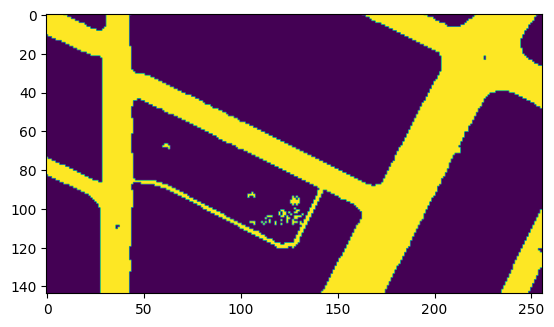

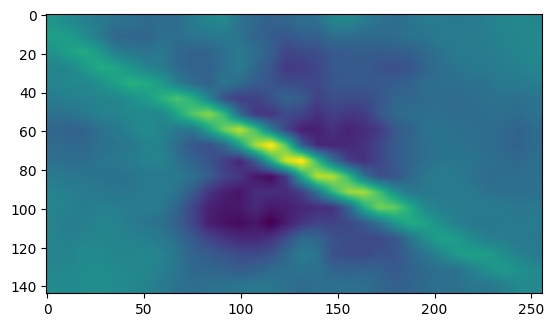

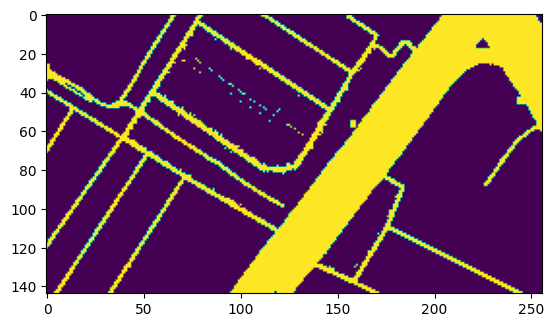

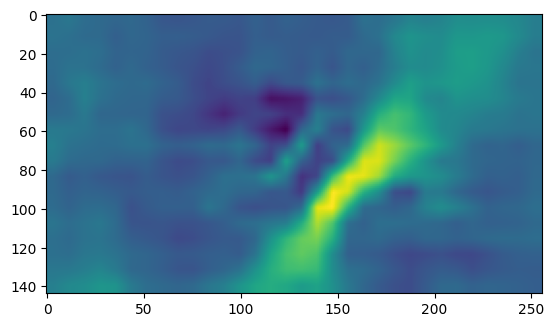

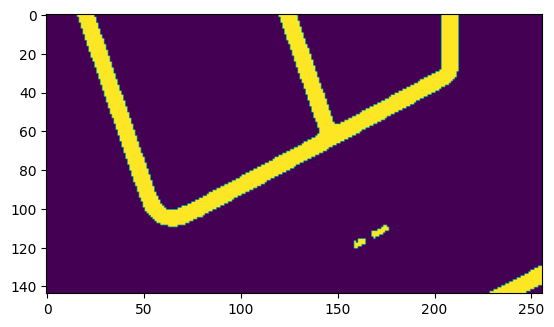

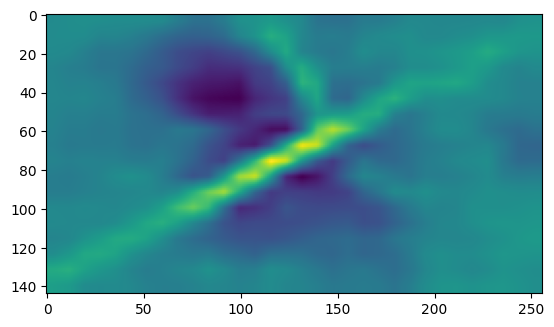

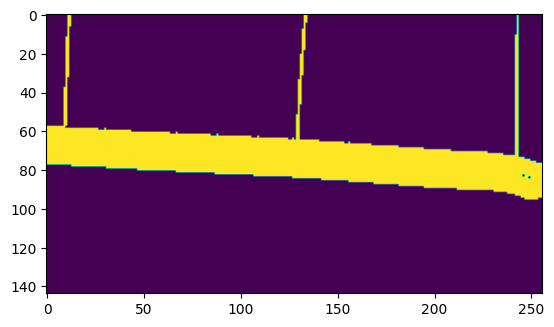

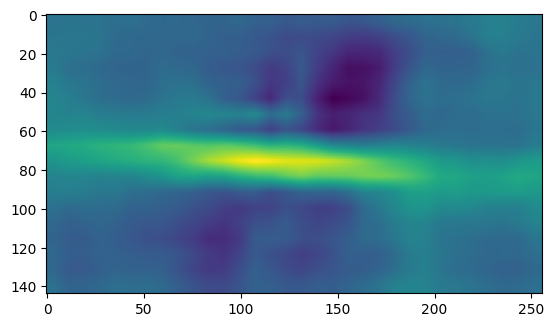

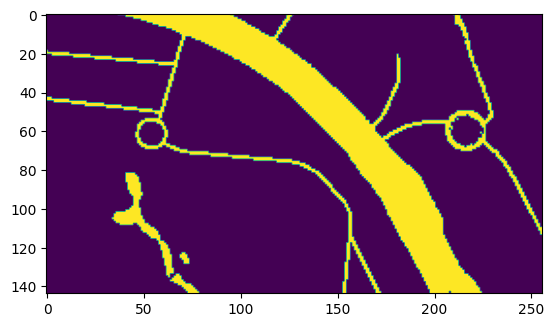

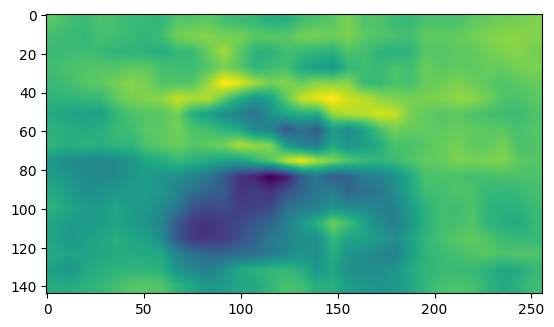

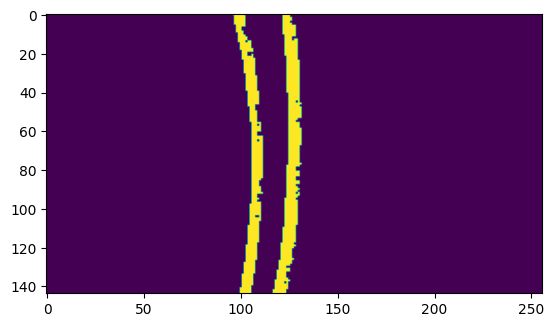

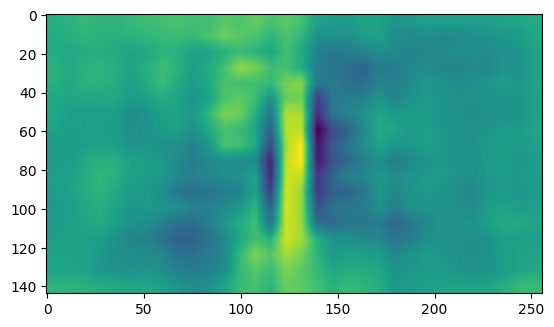

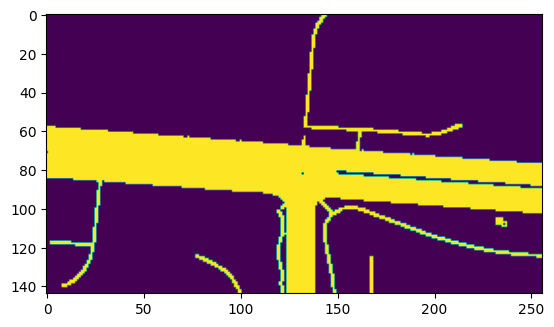

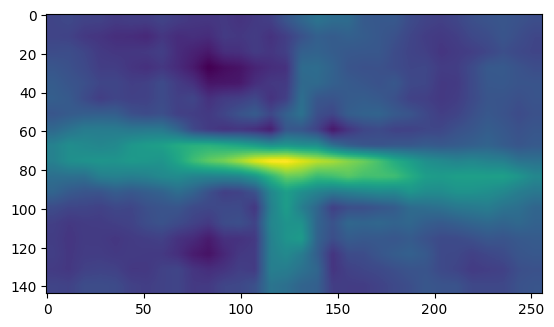

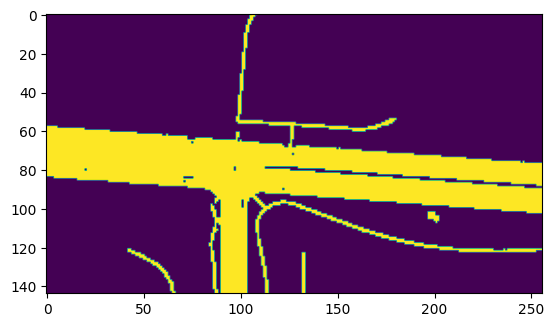

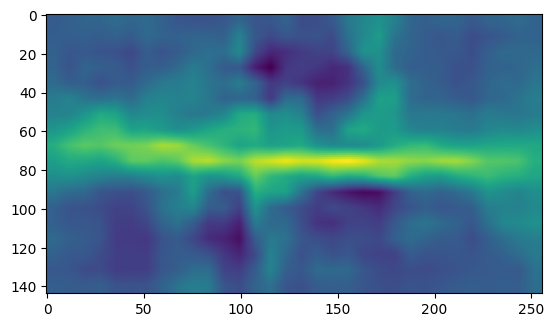

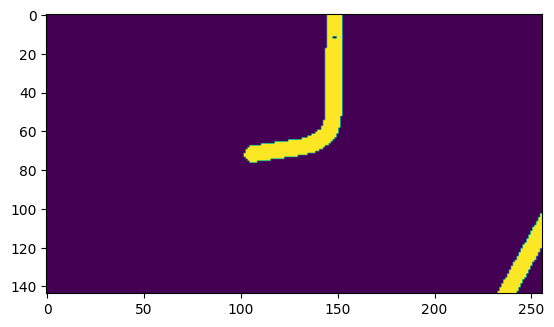

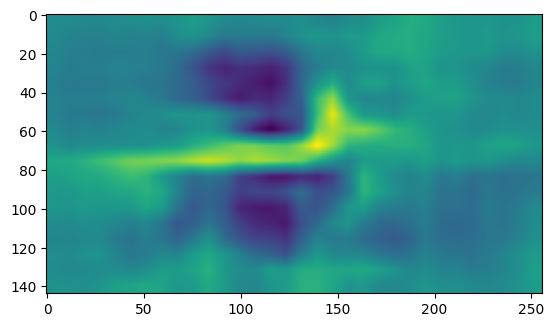

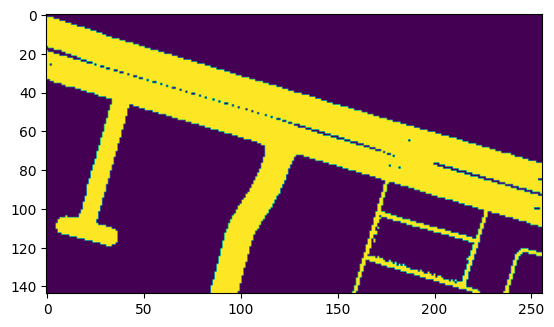

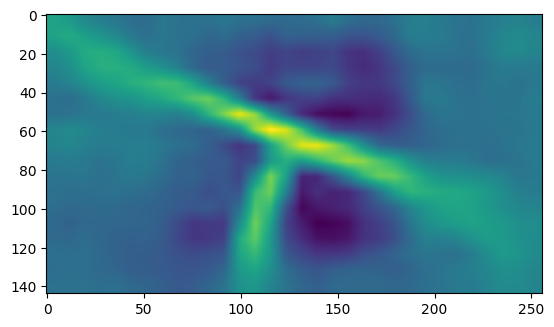

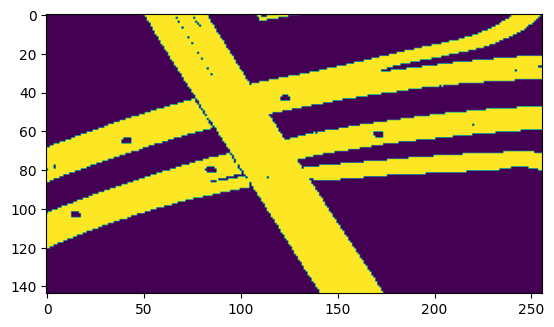

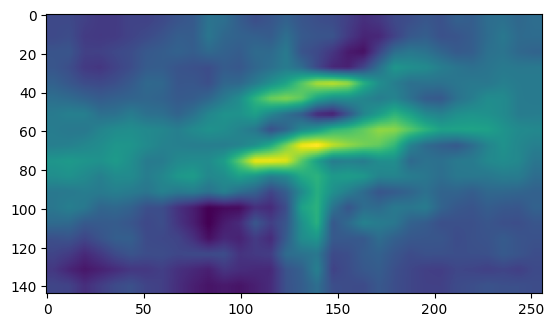

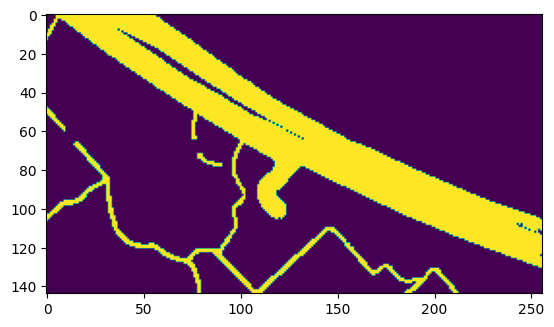

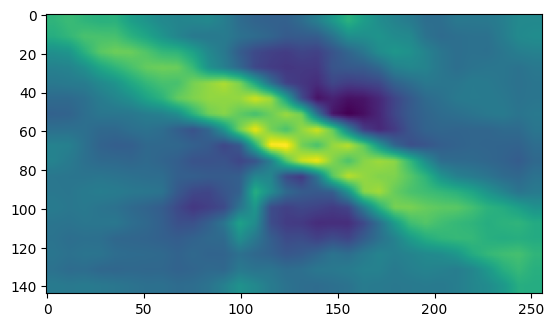

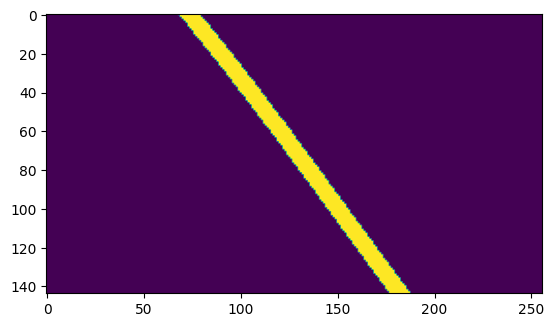

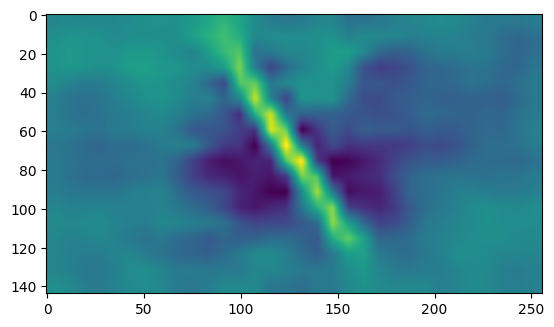

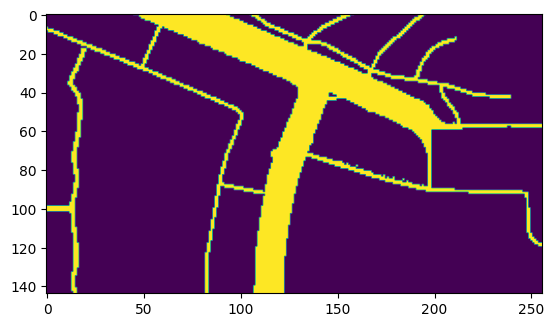

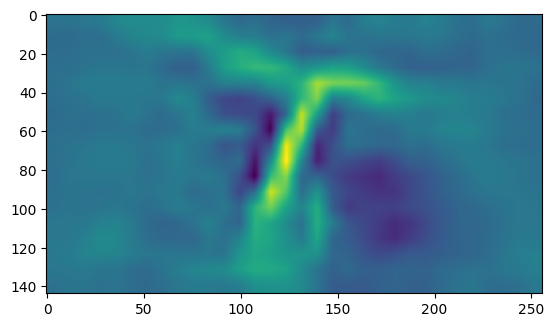

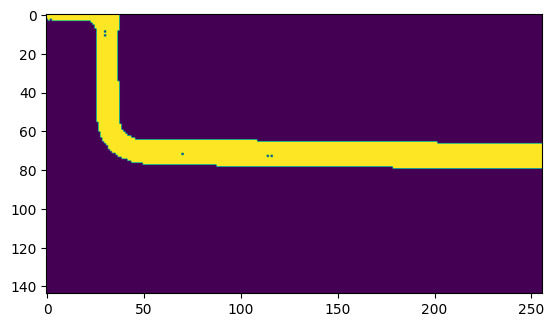

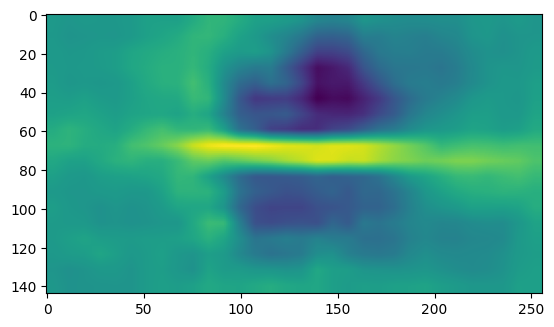

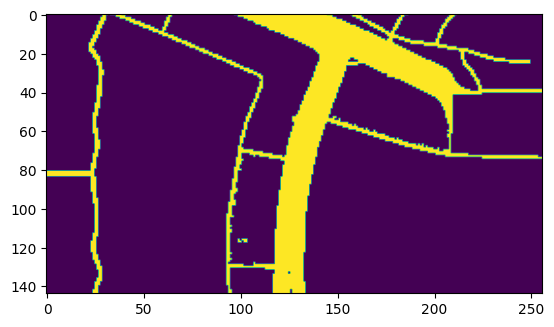

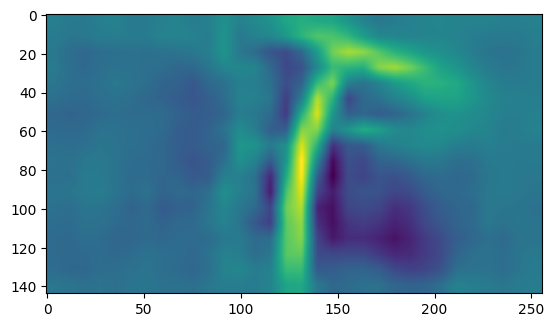

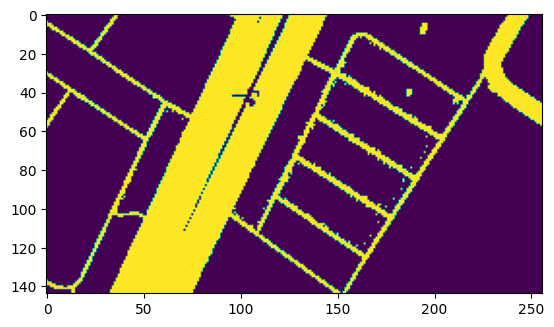

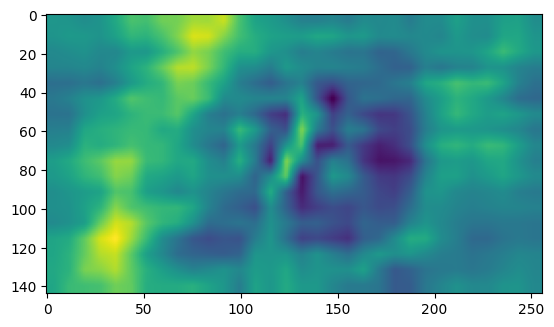

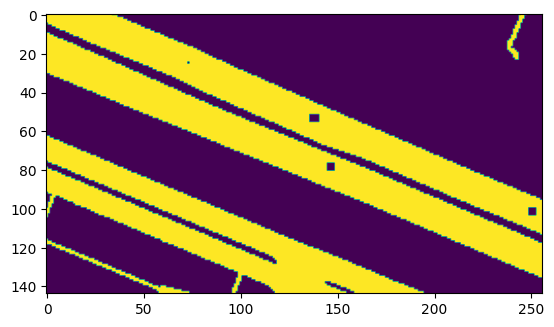

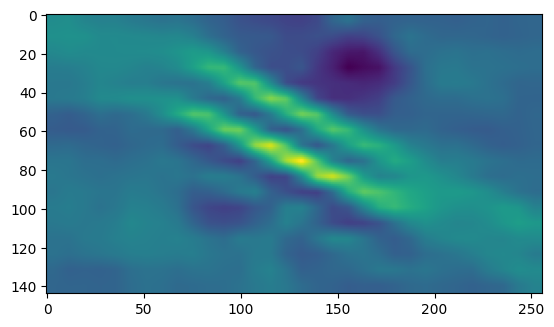

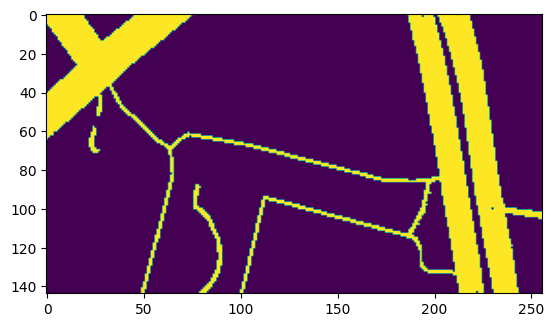

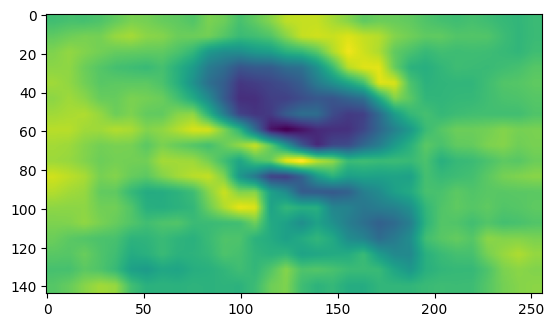

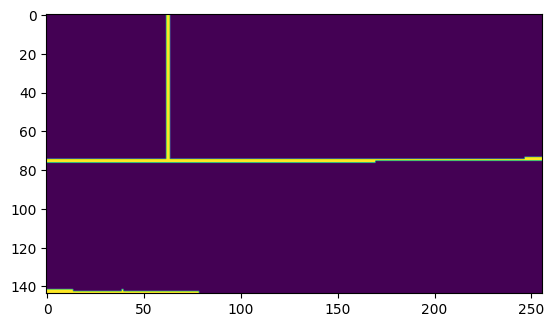

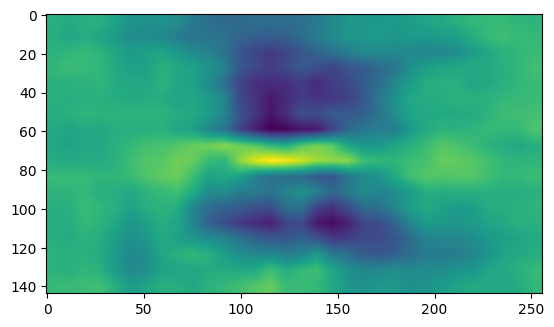

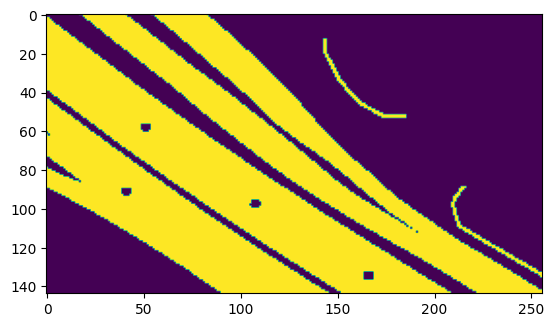

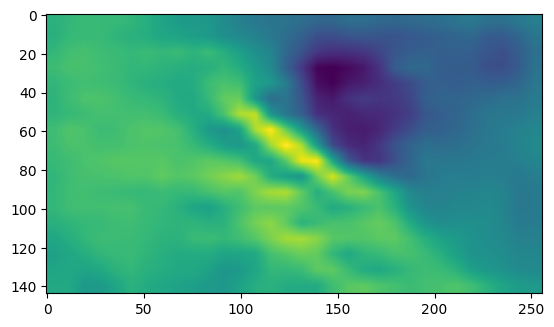

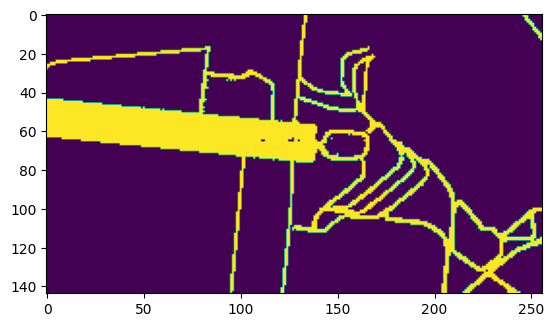

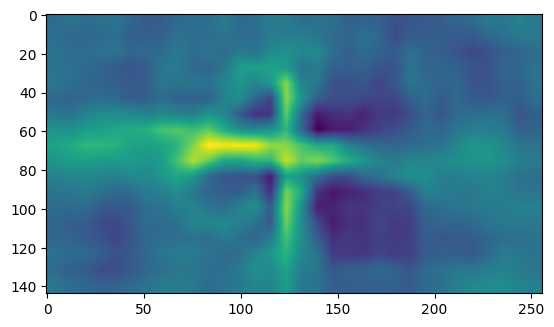

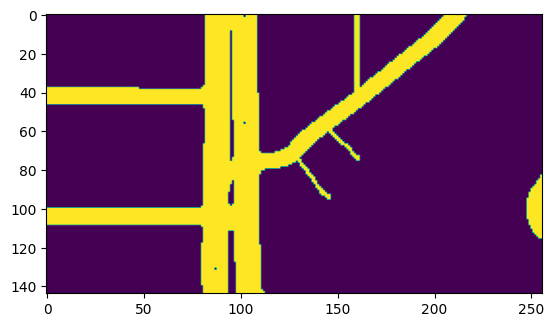

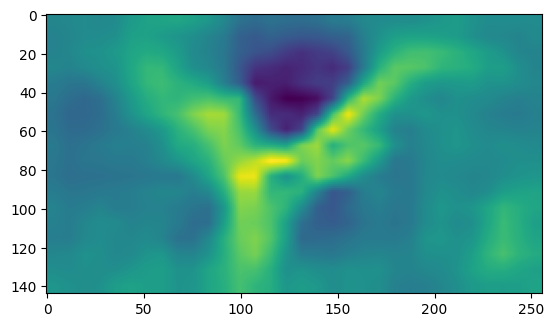

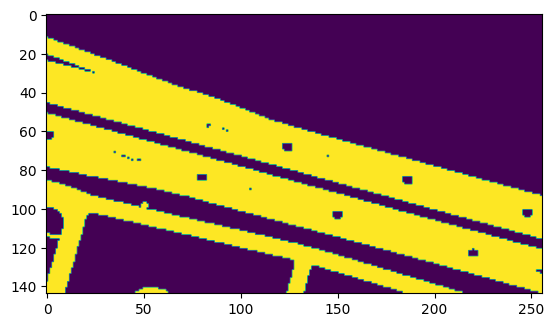

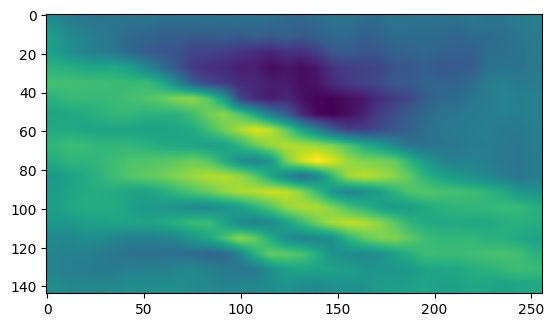

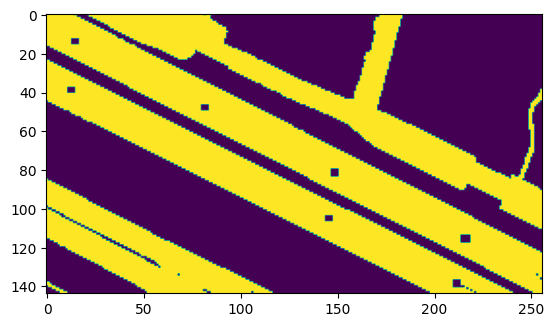

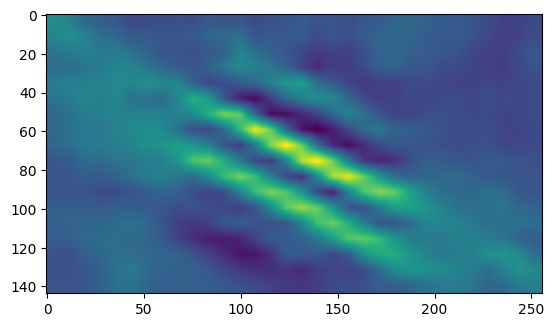

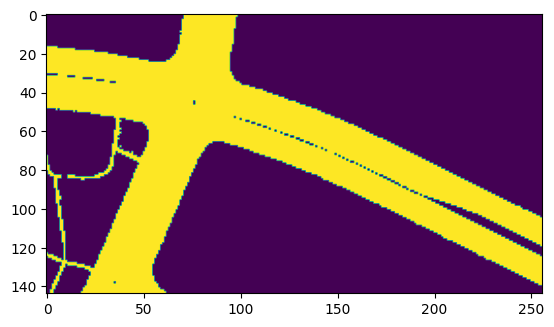

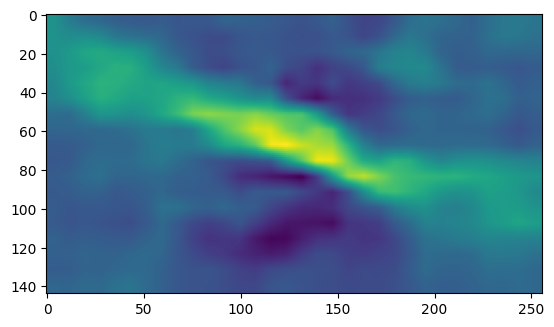

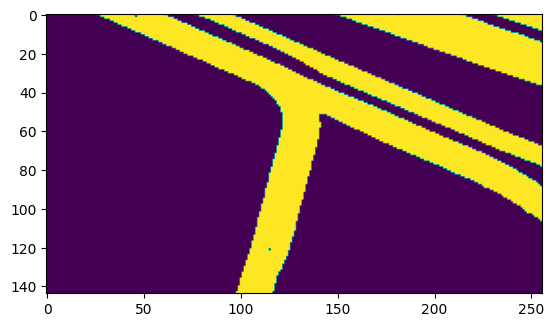

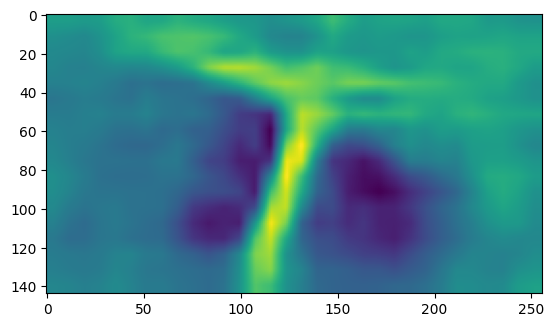

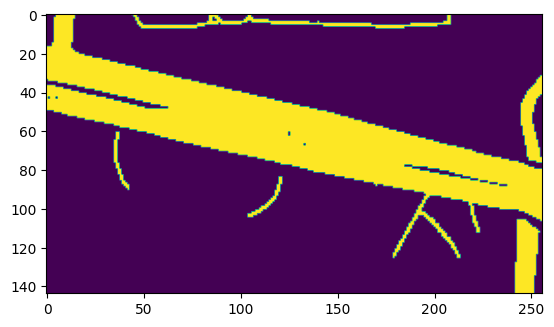

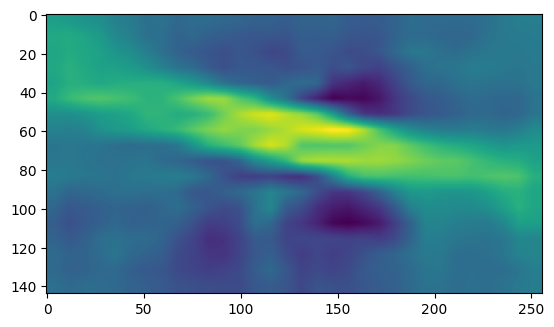

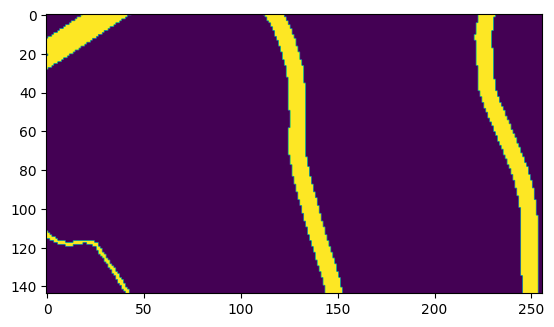

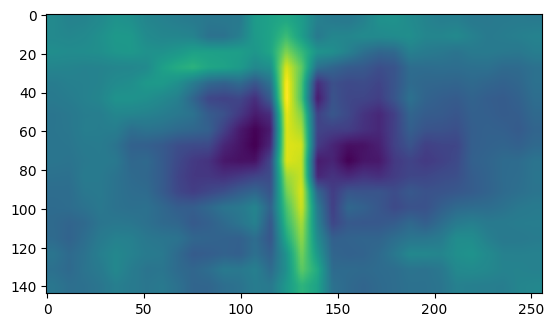

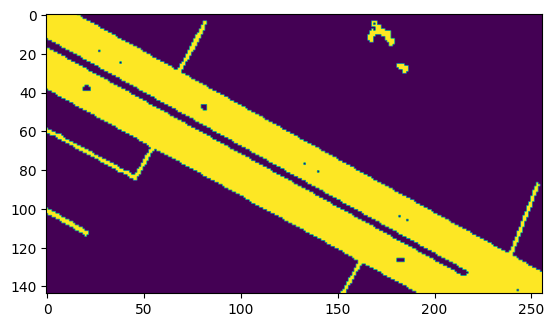

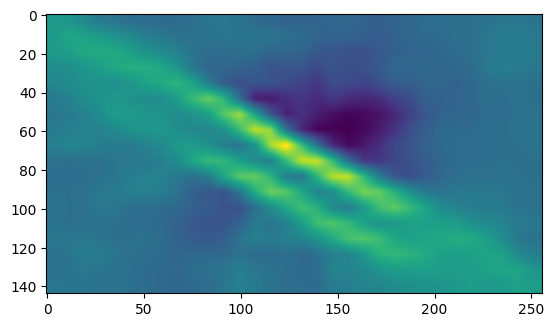

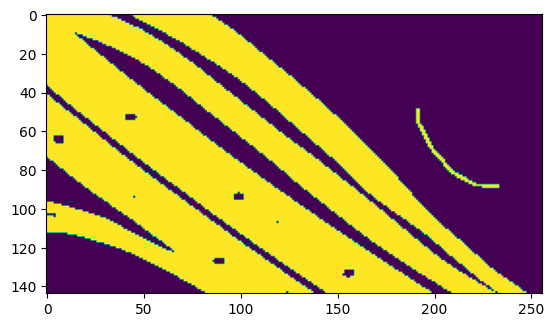

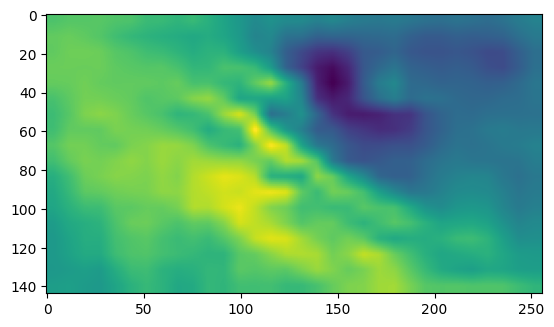

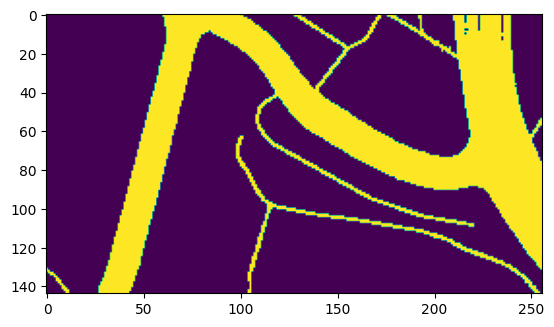

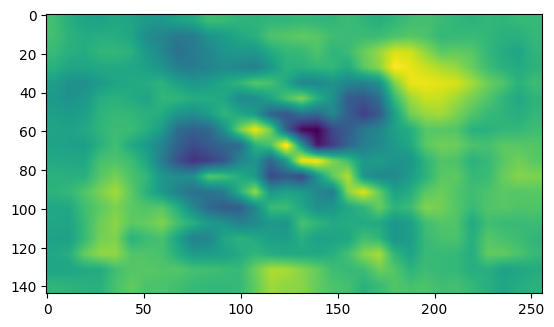

In [26]:

print(n.shape, e.shape, s.shape, w.shape, y.shape)

import matplotlib.pyplot as plt

def visualize(img, monochrome=False):
    if monochrome:
        plt.imshow(img)
    else:
        plt.imshow(img.permute(1,2,0))
    plt.show()

''' visualize(n[0])
visualize(e[0])
visualize(s[0])
visualize(w[0]) '''

for i in range(32):
  visualize(y[i][0],True)
  visualize(out[i][0]*255, True)
